<a href="https://colab.research.google.com/github/bposantos/NMR_spectra_assignment/blob/main/classificador_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador - Sistemas de *spins*
TOCSY - NOESY

## Bibliotecas

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
# Autenticar no Google
#auth.authenticate_user()
#creds, _ = default()
#gc = gspread.authorize(creds)

## Graph

### Debug

In [48]:
def debug_leu_pattern(G, nodes):
    """Função de debug para entender o padrão LEU"""
    print("\n=== DEBUG LEU PATTERN ===")
    print("Nós no grafo:", sorted(nodes))

    # Identificar o CB
    cb_candidates = [n for n in nodes if 39 <= n <= 43.5]
    print("\nCB candidates:", cb_candidates)

    if not cb_candidates:
        print("No CB found!")
        return

    cb = cb_candidates[0]
    print(f"\nCB found: {cb}")
    print("Connected to:", sorted(G.neighbors(cb)))

    # Verificar HBs
    hb_protons = [n for n in G.neighbors(cb) if 1.2 <= n <= 2.0]
    print("\nHB protons:", hb_protons)

    # Verificar CA
    ca_candidates = [n for n in nodes if 52 <= n <= 59 and any(3.0 <= x <= 5.5 for x in G.neighbors(n))]
    print("\nCA candidates:", ca_candidates)

    if ca_candidates:
        ca = ca_candidates[0]
        print(f"CA found: {ca}")
        print("Connected to:", sorted(G.neighbors(ca)))

        # Verificar HA
        ha_candidates = [n for n in G.neighbors(ca) if 3.0 <= n <= 5.5]
        print("\nHA candidates:", ha_candidates)

    # Verificar CDs
    cd_candidates = [n for n in nodes if (20 <= n <= 26)]
    print("\nCD candidates:", cd_candidates)

    for cd in cd_candidates:
        print(f"\nCD {cd} connected to:", sorted(G.neighbors(cd)))
        md_candidates = [n for n in G.neighbors(cd) if 0.5 <= n <= 1.1]
        print(f"MD candidates for CD {cd}: {md_candidates}")

    # Verificar conectividade
    print("\nChecking connectivity:")
    for node in nodes:
        print(f"{node}: connected to {sorted(G.neighbors(node))}")

In [49]:
def debug_pro_pattern(G, nodes):
    """Função de debug para entender o padrão PRO com os mesmos parâmetros de check_pro_pattern"""
    print("\n=== DEBUG PRO PATTERN ===")
    print("Nós no grafo:", sorted(nodes))

    # Verifica HN (deve estar ausente em PRO)
    hn_candidates = [n for n in nodes if 7 <= n <= 10]
    print("\nHN candidates (should be empty for PRO):", hn_candidates)
    if hn_candidates:
        print("! PRO should not have HN !")

    # Verifica CA
    ca_candidates = [n for n in nodes if 60 <= n <= 65]
    print("\nCA candidates (60-65 ppm):", ca_candidates)
    if not ca_candidates:
        print("No CA found!")
        return

    ca = max(ca_candidates)
    print(f"\nCA selected: {ca}")
    print("CA connected to:", sorted(G.neighbors(ca)))

    # Verifica HA
    ha = next((n for n in G.neighbors(ca) if 4.0 <= n <= 5.0), None)
    print("\nHA (4.0-5.0 ppm connected to CA):", ha)

    # Verifica CB
    cb_candidates = [n for n in nodes if 29 <= n <= 35]
    print("\nCB candidates (29-35 ppm):", cb_candidates)
    if not cb_candidates:
        print("No CB found!")
        return

    cb = cb_candidates[0]
    print(f"\nCB selected: {cb}")
    print("CB connected to:", sorted(G.neighbors(cb)))

    # Verifica HB
    hb_protons = [n for n in G.neighbors(cb) if 1.5 <= n <= 2.2]
    print("\nHB protons (1.5-2.2 ppm connected to CB):", hb_protons)
    if len(hb_protons) >= 2:
        hb_sorted = sorted(hb_protons)
        print(f"HB2: {hb_sorted[1]}, HB3: {hb_sorted[0]}")
    elif hb_protons:
        print(f"HB: {hb_protons[0]}")

    # Verifica CD
    cd_candidates = [n for n in nodes if 48 <= n <= 52]
    print("\nCD candidates (48-52 ppm):", cd_candidates)
    if cd_candidates:
        cd = cd_candidates[0]
        print(f"\nCD selected: {cd}")
        print("CD connected to:", sorted(G.neighbors(cd)))

        # Verifica HD
        hd_protons = [n for n in G.neighbors(cd) if 3.4 <= n <= 3.8]
        print("\nHD protons (3.4-3.8 ppm connected to CD):", hd_protons)
        if len(hd_protons) >= 2:
            hd_sorted = sorted(hd_protons)
            print(f"HD2: {hd_sorted[1]}, HD3: {hd_sorted[0]}")
        elif hd_protons:
            print(f"HD: {hd_protons[0]}")

    # Verifica CG
    cg_candidates = [n for n in nodes if 26 <= n <= 30]
    print("\nCG candidates (26-30 ppm):", cg_candidates)
    if cg_candidates:
        cg = cg_candidates[0]
        print(f"\nCG selected: {cg}")
        print("CG connected to:", sorted(G.neighbors(cg)))

        # Verifica HG
        hg_protons = [n for n in G.neighbors(cg) if 1.6 <= n <= 2.1]
        print("\nHG protons (1.6-2.1 ppm connected to CG):", hg_protons)
        if len(hg_protons) >= 2:
            hg_sorted = sorted(hg_protons)
            print(f"HG2: {hg_sorted[1]}, HG3: {hg_sorted[0]}")
        elif hg_protons:
            print(f"HG: {hg_protons[0]}")

    # Verifica conectividade geral
    print("\n=== CONECTIVIDADE COMPLETA ===")
    for node in sorted(nodes):
        print(f"{node:.2f} ppm: connected to {sorted(G.neighbors(node))}")

### Amino acids

#### GLY

In [4]:
def check_gly_pattern(G, nodes):
    """Padrão GLY: 2 HA no CA (43-47) e sem CB"""
    atoms = {}
    confidence = 0.0

    # Verifica CB e outros C
    cb_candidates = [n for n in nodes if (10 <= n <= 41) or (47 <= n <= 70)]
    if cb_candidates:
        return None, {}, 0.0
    confidence += 0.3

    # Verifica HB ou outros protons
    hb_candidates = [n for n in nodes if n <= 3]
    if hb_candidates:
        return None, {}, 0.0
    confidence += 0.3

    # Verifica CA
    ca_candidates = [n for n in nodes if 43 <= n <= 47]
    if not ca_candidates:
        return None, {}, 0.0
    ca = max(ca_candidates)
    atoms['CA'] = ca
    confidence += 0.3

    #Verifica HA
    ha_neighbors = [n for n in G.neighbors(ca) if 3.5 <= n <= 4.5]
    if len(ha_neighbors) < 1:
        return None, {}, 0.0

    # Verifica se Ha esta expandido ou colapsado
    if len(ha_neighbors) >= 2:
        ha_protons_sorted = sorted(ha_neighbors)
        atoms.update({"HA2": ha_protons_sorted[1], "HA3": ha_protons_sorted[0]})
    else:
        atoms["HA"] = ha_neighbors[0]
    confidence += 0.1

    # Busca de HN
    hn_candidates = [n for n in nodes if 7 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    return "GLY", atoms, round(confidence,2)

#### PRO

In [5]:
def check_pro_pattern(G, nodes):
    """Padrão PRO: Ausência de HN e CA ~60-65"""
    #debug_pro_pattern(G, nodes)
    atoms = {}
    confidence = 0.0

    # Verifica HN
    hn_candidates = [n for n in nodes if 7 <= n <= 10]
    if hn_candidates:
        return None, {}, 0.0

    # Verifica CA
    ca_candidates = [n for n in nodes if 60 <= n <= 65]
    if not ca_candidates:
        return None, {}, 0.0
    ca = max(ca_candidates)
    atoms['CA'] = ca
    confidence += 0.5

    # Verifica HA
    ha = next((n for n in G.neighbors(ca) if 4.0 <= n <= 5.0), None)
    if ha:
        atoms['HA'] = ha
        confidence += 0.2

    # Verifica CB
    cb = next((n for n in nodes if 29 <= n <= 35), None)
    if not cb:
      return None, {}, 0.0
    if cb:
        atoms['CB'] = cb
        confidence += 0.1

    # Verifica HB
    hb_protons = [n for n in G.neighbors(cb) if 1.5 <= n <= 2.2]
    if len(hb_protons) < 1:
        return None, {}, 0.0

    # Verifica se HB esta expandido ou colapsado
    if len(hb_protons) >= 2:
        hb_protons_sorted = sorted(hb_protons)
        atoms.update({"HB2": hb_protons_sorted[1], "HB3": hb_protons_sorted[0]})
    else:
        atoms["HB"] = hb_protons[0]
    confidence += 0.1

    # Verifica CD
    cd = next((n for n in nodes if 48 <= n <= 52), None)
    if cd:
        atoms['CD'] = cd
        confidence += 0.1

        # Verifica HD
        hd_protons = [n for n in G.neighbors(cd) if 3.4 <= n <= 3.8]

        # Verifica se HD esta expandido ou colapsado
        if len(hd_protons) >= 2:
            hd_protons_sorted = sorted(hd_protons)
            atoms.update({"HD2": hd_protons_sorted[1], "HD3": hd_protons_sorted[0]})
        else:
            atoms["HD"] = hd_protons[0]

    # Verifica CG
    cg = next((n for n in nodes if 26 <= n <= 30), None)
    if cg:
        atoms['CG'] = cg

        # Verifica HG
        hg_protons = [n for n in G.neighbors(cg) if 1.6 <= n <= 2.1]

        # Verifica se HG esta expandido ou colapsado
        if len(hg_protons) >= 2:
            hg_protons_sorted = sorted(hg_protons)
            atoms.update({"HG2": hg_protons_sorted[1], "HG3": hg_protons_sorted[0]})
        else:
            atoms["HG"] = hg_protons[0]

    return "PRO", atoms, round(min(confidence, 1.0),2)

#### ALA

In [6]:
def check_ala_pattern(G, nodes):
    """Padrão ALA: CB ~17-20 (+0.4), CA ~48-55 (+0.3), HB ~1-2 (+0.2), HA ~4-5(+0.1)"""
    atoms = {}
    confidence = 0.0

    # Identifica CB
    cb_candidates = [n for n in nodes if 18 <= n <= 20]
    if not cb_candidates:
        return None, {}, 0.0
    cb = max(cb_candidates)
    atoms['CB'] = cb
    confidence += 0.5

    # Busca HB conectado ao CB
    hb = next((n for n in G.neighbors(cb) if 1.0 <= n <= 2.0), None)
    if hb:
        atoms['HB'] = hb
        confidence += 0.2

    # Identifica CA
    ca_candidates = [n for n in nodes if 52 <= n <= 55]
    if ca_candidates:
        ca = max(ca_candidates)
        atoms['CA'] = ca
        confidence += 0.2

        # Busca HA conectado ao CA
        ha = next((n for n in G.neighbors(ca) if 4.0 <= n <= 5.0), None)
        if ha:
            atoms['HA'] = ha
            confidence += 0.1

    # Busca de HN
    hn_candidates = [n for n in nodes if 8 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        if ('HA' in atoms and hn in G.neighbors(atoms['HA'])) or \
           ('HB' in atoms and hn in G.neighbors(atoms['HB'])):
            atoms['HN'] = hn  # Não pontua, apenas registra

    return "ALA", atoms, round(min(confidence, 1.0),2)

#### ASN/ASP

In [7]:
def check_asn_asp_pattern(G, nodes):
    """Padrão ASN/ASP: CA ~48-55, CB ~34-40"""
    required = {'CA': (48, 55), 'CB': (34, 40)}
    atoms = {}
    confidence = 0.5

    # Verifica átomos básicos
    for atom, (min_val, max_val) in required.items():
        candidates = [n for n in nodes if min_val <= n <= max_val]
        if not candidates:
            return None, {}, 0.0
        atoms[atom] = max(candidates)
        confidence += 0.5

    # Verifica HB
    hb_protons = [n for n in G.neighbors(sorted(atoms.values())[0]) if 2.5 <= n <= 3.5]
    if len(hb_protons) < 1:
        return None, {}, 0.0

    # Verifica se HB esta expandido ou colapsado
    if len(hb_protons) >= 2:
        hb_protons_sorted = sorted(hb_protons)
        atoms.update({"HB2": hb_protons_sorted[1], "HB3": hb_protons_sorted[0]})
    else:
        atoms["HB"] = hb_protons[0]
    confidence += 0.1

    # Verifica HA
    ha = next((n for n in G.neighbors(sorted(atoms.values())[0]) if 4.0 <= n <= 5.0), None)
    if ha:
        atoms['HA'] = ha
        confidence += 0.1

    # Busca de HN
    hn_candidates = [n for n in nodes if 7 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    # Verifica se não é outro AA
    if has_his_pattern(G, nodes) or has_trp_pattern(G, nodes):
        return None, {}, 0.0

    return "ASN_OR_ASP", atoms, round(min(confidence, 1.0),2)

#### PHE

In [8]:
def check_phe_pattern(G, nodes):
    """Padrão PHE: CZ ~129 conectado a HZ ~7"""
    cz_candidates = [n for n in nodes if 131 <= n <= 132]
    if not cz_candidates:
        return None, {}, 0.0

    atoms = {}
    confidence = 0.5

    # Verifica CZ-HZ
    cz = max(cz_candidates)
    hz = next((n for n in G.neighbors(cz) if 6.5 <= n <= 7.5), None)
    if not hz:
        return None, {}, 0.0

    atoms.update({'CZ': cz, 'HZ': hz})
    confidence += 0.2

    # Verifica CA e CB
    ca = next((n for n in nodes if 52 <= n <= 59.5), None)
    if ca:
        atoms['CA'] = ca
        confidence += 0.1

    cb = next((n for n in nodes if 35 <= n <= 42), None)
    if cb:
        atoms['CB'] = cb
        confidence += 0.1

    # Verifica HB
    hb_protons = [n for n in nodes if 2.5 <= n <= 3.5]
    if len(hb_protons) < 1:
        return None, {}, 0.0

    # Verifica se HB esta expandido ou colapsado
    if len(hb_protons) >= 2:
        hb_protons_sorted = sorted(hb_protons)
        atoms.update({"HB2": hb_protons_sorted[1], "HB3": hb_protons_sorted[0]})
    else:
        atoms["HB"] = hb_protons[0]
    confidence += 0.05

    # Verifica HA
    ha = next((n for n in nodes if 3.9 <= n <= 5.5), None)
    if ha:
        atoms['HA'] = ha
        confidence += 0.05

    # Busca de HN
    hn_candidates = [n for n in nodes if 7.5 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    # Verifica se não é TYR
    if any(116 <= n <= 119 for n in nodes):  # CE da TYR
        return None, {}, 0.0

    return "PHE", atoms, round(min(confidence, 1.0),2)

#### TYR

In [9]:
def check_tyr_pattern(G, nodes):
    """Padrão TYR: CE ~117 e CD ~132, sem ~129-131"""
    ce_candidates = [n for n in nodes if 117 <= n <= 119]
    cd_candidates = [n for n in nodes if 131.9 <= n <= 133.5]

    if not ce_candidates or not cd_candidates:
        return None, {}, 0.0

    # Verifica se tem valores de PHE (~129-131)
    if any(129 <= n <= 131 for n in nodes):
        return None, {}, 0.0

    atoms = {'CE': max(ce_candidates), 'CD': max(cd_candidates)}
    confidence = 0.7

    # Verifica CA
    ca = next((n for n in nodes if 52 <= n <= 59.5), None)
    if ca:
        atoms['CA'] = ca
        confidence += 0.1

    # Verifica CB
    cb = next((n for n in nodes if 35 <= n <= 42), None)
    if cb:
        atoms['CB'] = cb
        confidence += 0.1

    # Verifica HB
    hb_protons = [n for n in G.neighbors(cb) if 2.5 <= n <= 3.5]
    if len(hb_protons) < 1:
        return None, {}, 0.0

    # Verifica se HB esta expandido ou colapsado
    if len(hb_protons) >= 2:
        hb_protons_sorted = sorted(hb_protons)
        atoms.update({"HB2": hb_protons_sorted[1], "HB3": hb_protons_sorted[0]})
    else:
        atoms["HB"] = hb_protons[0]
    confidence += 0.05

    # Verifica HA
    ha = next((n for n in G.neighbors(ca) if 3.9 <= n <= 5.5), None)
    if ha:
        atoms['HA'] = ha
        confidence += 0.05

    # Busca de HN
    hn_candidates = [n for n in nodes if 7.5 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    # Verifica HD
    hd_protons = [n for n in G.neighbors(atoms['CD'])if 6.5 <= n <= 7.5]

    # Verifica se HD esta expandido ou colapsado
    if len(hd_protons) >= 2:
        hd_protons_sorted = sorted(hd_protons)
        atoms.update({"HD1": hd_protons_sorted[1], "HD2": hd_protons_sorted[0]})
    else:
        atoms["HD"] = hd_protons[0]

    return "TYR", atoms, round(min(confidence, 1.0),2)

#### HIS

In [10]:
def check_his_pattern(G, nodes):
    """Padrão HIS: CD2 ~119 conectado a HD ~7"""
    cd2_candidates = [n for n in nodes if 118 <= n <= 120.9]
    if not cd2_candidates:
        return None, {}, 0.0

    cd2 = max(cd2_candidates)
    atoms = {'CD2': cd2}
    confidence = 0.4

    # Verifica HD
    hd_protons = [n for n in G.neighbors(atoms['CD2'])if 6.5 <= n <= 7.5]
    if not hd_protons:
        return None, {}, 0.0

    # Verifica se HD esta expandido ou colapsado
    if len(hd_protons) >= 2:
        hd_protons_sorted = sorted(hd_protons)
        atoms.update({"HD1": hd_protons_sorted[1], "HD2": hd_protons_sorted[0]})
    else:
        atoms["HD"] = hd_protons[0]

    confidence += 0.3

    # Verifica CA
    ca = next((n for n in nodes if 52 <= n <= 58), None)
    if ca:
        atoms['CA'] = ca
        confidence += 0.1

        # Verifica HA
        ha = next((n for n in G.neighbors(ca) if 3.9 <= n <= 5.5), None)
        if ha:
            atoms['HA'] = ha
            confidence += 0.05

    # Verifica CB
    cb = next((n for n in nodes if 25 <= n <= 30), None)
    if cb:
        atoms['CB'] = cb
        confidence += 0.1

        # Verifica HB
        hb_protons = [n for n in G.neighbors(cb) if 2.5 <= n <= 3.5]
        if len(hb_protons) < 1:
            return None, {}, 0.0

        # Verifica se HB esta expandido ou colapsado
        if len(hb_protons) >= 2:
            hb_protons_sorted = sorted(hb_protons)
            atoms.update({"HB2": hb_protons_sorted[1], "HB3": hb_protons_sorted[0]})
        else:
            atoms["HB"] = hb_protons[0]
        confidence += 0.05

    # Busca de HN
    hn_candidates = [n for n in nodes if 7.5 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    if confidence >= 0.7:
      return "HIS", atoms, round(min(confidence, 1.0),2)
    return None, {}, 0.0

#### TRP

In [11]:
def check_trp_pattern(G, nodes):
    """Padrão TRP: CD ~126 conectado a HD ~7 e CA > 58"""
    cd_candidates = [n for n in nodes if 125 <= n <= 127]
    ca_candidates = [n for n in nodes if 55 <= n <= 62]

    if not cd_candidates or not ca_candidates:
        return None, {}, 0.0

    ca = max(ca_candidates)
    cd = max(cd_candidates)
    hd = next((n for n in G.neighbors(cd) if 6.5 <= n <= 7.5), None)
    if not hd:
        return None, {}, 0.0

    atoms = {'CD': cd, 'HD1': hd, 'CA': ca}
    confidence = 0.8

    # Verifica CB
    cb = next((n for n in nodes if 25 <= n <= 30), None)
    if cb:
        atoms['CB'] = cb
        confidence += 0.1

        # Verifica HB
        hb_protons = [n for n in G.neighbors(cb) if 2.5 <= n <= 3.5]
        if len(hb_protons) < 1:
            return None, {}, 0.0

        # Verifica se HB esta expandido ou colapsado
        if len(hb_protons) >= 2:
            hb_protons_sorted = sorted(hb_protons)
            atoms.update({"HB2": hb_protons_sorted[1], "HB3": hb_protons_sorted[0]})
        else:
            atoms["HB"] = hb_protons[0]
        confidence += 0.05

    # Verifica HA
    ha = next((n for n in G.neighbors(ca) if 3.9 <= n <= 5.5), None)
    if ha:
        atoms['HA'] = ha
        confidence += 0.05

    # Busca de HN
    hn_candidates = [n for n in nodes if 7.5 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn


    return "TRP", atoms, round(min(confidence, 1.0),2)

#### CYS

In [12]:
def check_cys_pattern(G, nodes):
    """Padrão CYS: CB ~33 conectado a HB ~3"""
    cb_candidates = [n for n in nodes if 32 <= n <= 35.5]
    if not cb_candidates:
        return None, {}, 0.0

    atoms = {}
    confidence = 0.0

    cb = max(cb_candidates)
    if cb:
        atoms['CB'] = cb

        # Verifica HB
        hb_protons = [n for n in G.neighbors(cb) if 2.5 <= n <= 3.5]
        if len(hb_protons) < 1:
            return None, {}, 0.0

        # Verifica se HB esta expandido ou colapsado
        if len(hb_protons) >= 2:
            hb_protons_sorted = sorted(hb_protons)
            atoms.update({"HB2": hb_protons_sorted[1], "HB3": hb_protons_sorted[0]})
        else:
            atoms["HB"] = hb_protons[0]
        confidence += 0.7


    # Verifica CA
    ca = next((n for n in nodes if 57 <= n <= 62), None)
    if ca:
        atoms['CA'] = ca
        confidence += 0.2

        # Verifica HA
        ha = next((n for n in G.neighbors(ca) if 3.9 <= n <= 5.5), None)
        if ha:
            atoms['HA'] = ha
            confidence += 0.1

    # Busca de HN
    hn_candidates = [n for n in nodes if 7.5 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    # Verifica se não é LYS (HB < 2)
    if any(n < 2 for n in nodes if any(30 <= x <= 35 for x in G.neighbors(n))):
        return None, {}, 0.0

    return "CYS", atoms, round(min(confidence, 1.0),2)

#### MET

In [13]:
def check_met_pattern(G, nodes):
    """Padrão MET: Dois sinais ~32 e ~33, mais sinal ~17"""

    cb_cg_candidates = [n for n in nodes if 31 <= n <= 34]
    if len(cb_cg_candidates) < 2:
        return None, {}, 0.0

    cb = max(cb_cg_candidates)
    cg = min(cb_cg_candidates)

    atoms = {'CB': cb, 'CG': cg}
    confidence = 0.6

    # Verifica sinal ~17 (CE)
    if not any(15 <= n <= 18.5 for n in nodes):
        return None, {}, 0.0

    atoms['CE'] = next((n for n in nodes if 16 <= n <= 18.5), None)
    confidence += 0.1

    # Verifica ME
    he = next((n for n in G.neighbors(atoms['CE']) if 1.3 <= n <= 2), None)
    if he:
        atoms['ME'] = he

    if atoms['CG']:
        # Verifica HG
        hg_protons = [n for n in G.neighbors(cg) if 2.2 <= n <= 2.7]

        # Verifica se HB esta expandido ou colapsado
        if len(hg_protons) >= 2:
            hg_protons_sorted = sorted(hg_protons)
            atoms.update({"HG2": hg_protons_sorted[1], "HG3": hg_protons_sorted[0]})
        else:
            atoms["HG"] = hg_protons[0]

    if atoms['CB']:
        # Verifica HB
        hb_protons = [n for n in G.neighbors(cb) if 1.5 <= n <= 2.5]
        if len(hb_protons) < 1:
            return None, {}, 0.0

        # Verifica se HB esta expandido ou colapsado
        if len(hb_protons) >= 2:
            hb_protons_sorted = sorted(hb_protons)
            atoms.update({"HB2": hb_protons_sorted[1], "HB3": hb_protons_sorted[0]})
        else:
            atoms["HB"] = hb_protons[0]
        confidence += 0.1

    # Verifica CA
    ca = next((n for n in nodes if 55 <= n <= 60), None)
    atoms['CA'] = ca
    confidence += 0.1

    if ca:
        # Verifica HA
        ha = next((n for n in G.neighbors(ca) if 3.9 <= n <= 5.5), None)
        atoms['HA'] = ha
        confidence += 0.1

    # Busca de HN
    hn_candidates = [n for n in nodes if 7.5 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    return "MET", atoms, round(min(confidence, 1.0),2)

#### LYS

In [14]:
def check_lys_pattern(G, nodes):
    """Padrão LYS: CB ~33 conectado a HB < 2"""
    cb_candidates = [n for n in nodes if 31.5 <= n <= 34]
    if not cb_candidates:
        return None, {}, 0.0

    cb = max(cb_candidates)

    if cb:
        atoms = {'CB': cb}

        # Verifica HB
        hb_protons = [n for n in G.neighbors(cb) if 1.5 <= n <= 2.1]
        if len(hb_protons) < 1:
            return None, {}, 0.0

        # Verifica se HB esta expandido ou colapsado
        if len(hb_protons) >= 2:
            hb_protons_sorted = sorted(hb_protons)
            atoms.update({"HB2": hb_protons_sorted[1], "HB3": hb_protons_sorted[0]})
        else:
            atoms["HB"] = hb_protons[0]


    confidence = 0.7

    # Verifica CE ~42 conectado a HE ~3
    ce = next((n for n in nodes if 41 <= n <= 43), None)
    if not ce:
      return None, {}, 0.0

    if ce:
        atoms['CE'] = ce
        # Verifica HE
        he_protons = [n for n in G.neighbors(ce) if 2.7 <= n <= 3.4]
        if len(he_protons) < 1:
            return None, {}, 0.0

        # Verifica se HE esta expandido ou colapsado
        if len(he_protons) >= 2:
            he_protons_sorted = sorted(he_protons)
            atoms.update({"HE2": he_protons_sorted[1], "HE3": he_protons_sorted[0]})
        else:
            atoms["HE"] = he_protons[0]

    # Verifica CA
    ca = next((n for n in nodes if 55 <= n <= 58), None)
    atoms['CA'] = ca
    confidence += 0.1

    # Verifica HA
    ha = next((n for n in nodes if 3.9 <= n <= 5.5), None)
    atoms['HA'] = ha
    confidence += 0.1

    # Verifica CD
    cd = next((n for n in nodes if 27 <= n <= 30), None)
    if cd:
        atoms['CD'] = cd
        confidence += 0.1

        # Verifica HD
        hd_protons = [n for n in G.neighbors(cd) if 1.4 <= n <= 1.8]

        # Verifica se HD esta expandido ou colapsado
        if len(hd_protons) >= 2:
            hd_protons_sorted = sorted(hd_protons)
            atoms.update({"HD2": hd_protons_sorted[1], "HD3": hd_protons_sorted[0]})
        else:
            atoms["HD"] = hd_protons[0]

    # Verifica CG
    cg = next((n for n in nodes if 23 <= n <= 26), None)
    if cg:
        atoms['CG'] = cg

        # Verifica HG
        hg_protons = [n for n in G.neighbors(cg) if 1.3 <= n <= 1.7]

        # Verifica se HG esta expandido ou colapsado
        if len(hg_protons) >= 2:
            hg_protons_sorted = sorted(hg_protons)
            atoms.update({"HG2": hg_protons_sorted[1], "HG3": hg_protons_sorted[0]})
        else:
            atoms["HG"] = hg_protons[0]

    # Busca de HN
    hn_candidates = [n for n in nodes if 7.5 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn


    return "LYS", atoms, round(min(confidence, 1.0),2)

#### LEU

In [25]:
def check_leu_pattern(G, nodes):
    #debug_leu_pattern(G, nodes)
    atoms = {}
    confidence = 0.0

    # 1. Verifica HN
    hn_candidates = [n for n in nodes if 7.5 <= n <= 9]
    if hn_candidates:
        hn = hn_candidates[0]
        atoms["HN"] = hn

    # 2. Verifica CB
    cb = next((n for n in nodes if 39 <= n <= 44), None)
    if not cb:
        return None, {}, 0.0

    if cb:
        atoms["CB"] = cb
        confidence += 0.3

        # Verifica HB
        hb_protons = [n for n in G.neighbors(cb) if 1.5 <= n <= 2.2]
        if len(hb_protons) < 1:
            return None, {}, 0.0

        if len(hb_protons) >= 2:
            hb_protons_sorted = sorted(hb_protons)
            atoms.update({"HB2": hb_protons_sorted[0], "HB3": hb_protons_sorted[1]})
        else:
            atoms["HB"] = hb_protons[0]
        confidence += 0.2

    # 3. Verifica CA
    ca_candidates = [n for n in nodes if 52 <= n <= 59 and any(3.5 <= neighbor <= 5.5 for neighbor in G.neighbors(n))]
    if not ca_candidates:
        return None, {}, 0.0

    ca = ca_candidates[0]
    atoms["CA"] = ca
    confidence += 0.2

    # Verifica HA
    ha_candidates = [n for n in G.neighbors(ca) if 3.5 <= n <= 5.5]
    if ha_candidates:
        ha = ha_candidates[0]
        atoms["HA"] = ha
        confidence += 0.1

    # 4. Verifica CD
    cd_candidates = [n for n in nodes if 23 <= n <= 25]
    if cd_candidates:
        if len(cd_candidates) >= 2:
            connected_cds = sorted(cd_candidates)
            atoms.update({"CD1": connected_cds[1], "CD2": connected_cds[0]})
        else:
            connected_cds = sorted(cd_candidates)  # Initialize connected_cds here
            atoms["CD"] = connected_cds[0]
        confidence += 0.3

    # Verifica MD
    md_protons = [n for n in nodes if 0.6 <= n <= 0.9]
    if md_protons:
      if len(md_protons) >= 2:
        md_protons_sorted = sorted(md_protons)
        atoms.update({"MD1": md_protons_sorted[1], "MD2": md_protons_sorted[0]})
      else:
        atoms["MD"] = md_protons_sorted[0]


    # Busca de HN
    hn_candidates = [n for n in nodes if 7.5 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    # 5. HG (proton conectado ao HN que sobrou)
    hg_candidates = [n for n in G.neighbors(hn) if 1.4 <= n <= 1.6 and n not in hb_protons]

    if hg_candidates:
        hg = hg_candidates[0]
        atoms["HG"] = hg
        confidence += 0.05

        # 6. CG (carbono conectado ao HG)
        cg_candidates = [n for n in G.neighbors(hg) if 25 <= n <= 28.5]
        if cg_candidates:
            atoms["CG"] = cg_candidates[0]
            confidence += 0.05

    return "LEU", atoms, round(min(confidence, 1.0),2)

#### GLN/GLU

In [16]:
def check_gln_glu_pattern(G, nodes):
    """Padrão GLN/GLU: CA ~52-58, CB ~26-32"""
    ca_candidates = [n for n in nodes if 54 <= n <= 58]
    cb_candidates = [n for n in nodes if 27 <= n <= 31]

    if not ca_candidates or not cb_candidates:
        return None, {}, 0.0

    atoms = {'CA': max(ca_candidates), 'CB': max(cb_candidates)}
    confidence = 0.6

    # Verifica se não é outro AA
    if has_lys_pattern(G, nodes) or has_met_pattern(G, nodes):
        return None, {}, 0.0

    # Verifica HA
    ha = next((n for n in G.neighbors(atoms['CA']) if 3.9 <= n <= 5.5), None)
    if ha:
        atoms['HA'] = ha
        confidence += 0.1

    # Verifica HB
    hb_protons = [n for n in G.neighbors(atoms['CB']) if 1.5 <= n <= 2.2]
    if len(hb_protons) >= 2:
        hb_protons_sorted = sorted(hb_protons)
        atoms.update({"HB2": hb_protons_sorted[0], "HB3": hb_protons_sorted[1]})
    else:
        atoms["HB"] = hb_protons[0]
    confidence += 0.2

    # Verifica CG
    cg = next((n for n in nodes if 32 <= n <= 35), None)
    if cg:
        atoms['CG'] = cg

        # Verifica HG
        hg_protons = [n for n in G.neighbors(cg) if 2.1 <= n <= 2.5]
        if len(hg_protons) >= 2:
            hg_protons_sorted = sorted(hg_protons)
            atoms.update({"HG2": hg_protons_sorted[1], "HG3": hg_protons_sorted[0]})
        else:
            atoms["HG"] = hg_protons[0]
        confidence += 0.1

    # Busca de HN
    hn_candidates = [n for n in nodes if 8 <= n <= 10]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    return "GLN_OR_GLU", atoms, round(min(confidence, 1.0),2)

#### SER

In [17]:
def check_ser_pattern(G, nodes):
    """Padrão SER: CB ~63 conectado a HB ~3.8"""
    cb_candidates = [n for n in nodes if 60 <= n <= 65]
    if not cb_candidates:
        return None, {}, 0.0

    cb = max(cb_candidates)
    if cb:
        atoms = {'CB': cb}
        confidence = 0.6
        # Verifica HB
        hb_protons = [n for n in G.neighbors(cb) if 3.5 <= n <= 4]
        if not hb_protons:
            return None, {}, 0.0
        if len(hb_protons) >= 2:
            hb_protons_sorted = sorted(hb_protons)
            atoms.update({"HB2": hb_protons_sorted[0], "HB3": hb_protons_sorted[1]})
        else:
            atoms["HB"] = hb_protons[0]
        confidence += 0.1


    # Verifica CA
    ca = next((n for n in nodes if 55 <= n <= 60), None)
    if ca:
        atoms['CA'] = ca
        confidence += 0.2
            # Verifica HA
        ha = next((n for n in G.neighbors(ca) if 4 < n <= 5.5), None)
        if ha:
            atoms['HA'] = ha
            confidence += 0.1

    # Busca de HN
    hn_candidates = [n for n in nodes if 7.5 <= n <= 9]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    return "SER", atoms, min(confidence, 1.0)

#### THR

In [18]:
def check_thr_pattern(G, nodes):
    """Padrão THR revisado: CB ~69, HB ≥ 4, CG2 e CA não conectados a CB diretamente"""
    atoms = {}
    confidence = 0.0

    # 1. Detectar CB
    cb_candidates = [n for n in nodes if 65 <= n <= 70]
    if not cb_candidates:
        return None, {}, 0.0

    cb = max(cb_candidates)
    hb = next((n for n in G.neighbors(cb) if n >= 4), None)
    if not hb:
        return None, {}, 0.0

    atoms['CB'] = cb
    atoms['HB'] = hb
    confidence += 0.8

    # 2. Detectar HN
    hn_candidates = [n for n in nodes if 7 <= n <= 9]  # corrigido!
    hn = hn_candidates[0] if hn_candidates else None
    if hn:
        atoms["HN"] = hn
        confidence += 0.1

    # 3. Detectar CG2 (18–23 ppm) e garantir que **não é vizinho de CB**
    cg2_candidates = [n for n in nodes if 18 <= n <= 23 and n not in G.neighbors(cb)]
    if cg2_candidates:
        cg2 = cg2_candidates[0]
        atoms['CG2'] = cg2
        confidence += 0.05

        # MG: metil ligado a CG2 (~0.6–1.3 ppm)
        mg_candidates = [n for n in G.neighbors(cg2) if 0.6 <= n <= 1.3]
        if mg_candidates:
            atoms['MG'] = mg_candidates[0]
            confidence += 0.05

    # 4. Detectar CA (55–65 ppm), que **não seja vizinho de CB**
    ca_candidates = [n for n in nodes if 55 <= n <= 65 and n not in G.neighbors(cb)]
    ca = ca_candidates[0] if ca_candidates else None
    if ca:
        atoms['CA'] = ca
        confidence += 0.05

    # 5. Detectar HA: vizinho de CA ou de HN, ppm entre 3.5–5.0
    if ca or hn:
        ha_candidates = []
        if ca:
            ha_candidates += [n for n in G.neighbors(ca) if 3.5 <= n <= 5.0]
        if hn:
            ha_candidates += [n for n in G.neighbors(hn) if 3.5 <= n <= 5.0]
        ha_candidates = list(set(ha_candidates))
        if ha_candidates:
            atoms['HA'] = ha_candidates[0]
            confidence += 0.05

    return "THR", atoms, min(confidence, 1.0)

#### VAL

In [19]:
def check_val_pattern(G, nodes):
    """Padrão VAL: CG ~21 conectado a HG < 1"""
    atoms = {}

    mg_protons = [n for n in nodes if n < 1]
    if not mg_protons:
        return None, {}, 0.0
    cg_candidates = [n for n in nodes if 20 <= n <= 23]
    if not cg_candidates:
        return None, {}, 0.0

    if len(cg_candidates) >= 2:
        mg_protons_sorted = sorted(mg_protons)
        atoms.update({"MG1": mg_protons_sorted[1], "MG2": mg_protons_sorted[0]})
        cg_sorted = sorted(cg_candidates)
        atoms.update({"CG1": cg_sorted[1], "CG2": cg_sorted[0]})
    else:
        atoms["CG"] = cg_candidates[0]
        atoms["MG"] = mg_protons[0]

    confidence = 0.7

    # Verifica CB e CA
    cb = next((n for n in nodes if 25 <= n <= 35), None)
    if cb:
        atoms['CB'] = cb

        # Busca HB conectado ao CB
        hb = next((n for n in G.neighbors(cb) if 1.6 <= n <= 2.2), None)
        if hb:
            atoms['HB'] = hb
            confidence += 0.2

    ca = next((n for n in nodes if 55 <= n <= 65), None)
    if ca:
        atoms['CA'] = ca
        confidence += 0.1

        # Busca HA conectado ao CA
        ha = next((n for n in G.neighbors(ca) if 3.9 <= n <= 5.5), None)
        if ha:
            atoms['HA'] = ha

    # Busca HN
    hn_candidates = [n for n in nodes if 7 <= n <= 9]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    return "VAL", atoms, round(min(confidence, 1.0))

#### ILE

In [20]:
def check_ile_pattern(G, nodes):
    """Padrão ILE: CA > 60, CB ~38 conectado a HB < 2"""
    ca_candidates = [n for n in nodes if n > 60]
    if not ca_candidates:
        return None, {}, 0.0

    ca = max(ca_candidates)
    cb = next((n for n in nodes if 35 <= n <= 40), None)
    if not cb:
        return None, {}, 0.0

    hb = next((n for n in G.neighbors(cb) if 1 <= n <= 2), None)
    if not hb:
        return None, {}, 0.0

    atoms = {'CA': ca, 'CB': cb, 'HB': hb}
    confidence = 0.8

    # Verifica HA
    ha = next((n for n in G.neighbors(ca) if 3.9 <= n <= 5.5), None)
    if ha:
        atoms['HA'] = ha

    # Verifica CG1
    cg1 = next((n for n in nodes if 25 <= n <= 29.5), None)
    if cg1:
        atoms['CG1'] = cg1
        confidence += 0.1

        # Verifica HG1
        hg1_protons = [n for n in G.neighbors(cg1) if 1 <= n <= 1.5]
        if len(hg1_protons) > 1:
            hg1_protons_sorted = sorted(hg1_protons)
            atoms.update({"HG11": hg1_protons_sorted[0], "HG12": hg1_protons_sorted[1]})
        else:
            atoms["HG1"] = hg1_protons[0]

    cg2 = next((n for n in nodes if 15 <= n <= 20), None)
    if cg2:
        atoms['CG2'] = cg2
        mg = next((n for n in G.neighbors(cg2) if 0.6 <= n <= 0.9), None)
        if mg:
            atoms['MG'] = mg

    cd1 = next((n for n in nodes if 12 <= n <= 15), None)
    if cd1:
        atoms['CD1'] = cd1
        md = next((n for n in G.neighbors(cd1) if 0.6 <= n <= 0.9), None)
        if md:
            atoms['MD'] = md

    # Busca HN
    hn_candidates = [n for n in nodes if 7 <= n <= 9]
    if hn_candidates:
        hn = max(hn_candidates)
        atoms['HN'] = hn

    return "ILE", atoms, min(confidence, 1.0)

#### Auxiliar Functions

In [21]:
# --------------------------------------------------
# Funções auxiliares
# --------------------------------------------------

def has_his_pattern(G, nodes):
    """Verifica padrão de HIS (CD2 ~119 conectado a HD ~7)"""
    cd2 = next((n for n in nodes if 118 <= n <= 120), None)
    if not cd2:
        return False
    return any(6.5 <= n <= 7.5 for n in G.neighbors(cd2))

def has_trp_pattern(G, nodes):
    """Verifica padrão de TRP (CD ~126 conectado a HD ~7)"""
    cd = next((n for n in nodes if 125 <= n <= 127), None)
    if not cd:
        return False
    return any(6.5 <= n <= 7.5 for n in G.neighbors(cd))

def has_phe_pattern(G, nodes):
    """Verifica se tem padrão de PHE (CZ ~129 e HZ ~7)"""
    cz = next((n for n in nodes if 128 <= n <= 132), None)
    if not cz:
        return False
    return any(6.5 <= n <= 7.5 for n in G.neighbors(cz))

def has_lys_pattern(G, nodes):
    """Verifica padrão de LYS (CB ~33 com HB < 2)"""
    cb = next((n for n in nodes if 32 <= n <= 34), None)
    if not cb:
        return False
    return any(n < 2 for n in G.neighbors(cb))

def has_met_pattern(G, nodes):
    """Verifica padrão de MET (dois sinais ~32-33 e sinal ~17)"""
    cb_signals = [n for n in nodes if 31 <= n <= 34]
    return len(cb_signals) >= 2 and any(16 <= n <= 18 for n in nodes)

### Fuction

In [22]:
from collections import defaultdict
import networkx as nx

def identify_aa_v2(ppm_pairs, show_graph=False):
    G = nx.Graph()
    for pair in ppm_pairs:
        try:
            a, b = map(float, pair.split('-'))
            G.add_edge(a, b)
        except:
            continue

    def safe_get_neighbors(node):
        return list(G.neighbors(node)) if node in G else []

    nodes = [n for n in G.nodes if isinstance(n, (int, float))]
    if not nodes:
        return "UNKNOWN", {}

    # Ordem de verificação otimizada
    aa_check_order = [
        ('GLY', check_gly_pattern),
        ('PRO', check_pro_pattern),
        ('ALA', check_ala_pattern),
        ('THR', check_thr_pattern),
        ('VAL', check_val_pattern),
        ('ILE', check_ile_pattern),
        ('PHE', check_phe_pattern),
        ('TYR', check_tyr_pattern),
        ('HIS', check_his_pattern),
        ('TRP', check_trp_pattern),
        ('CYS', check_cys_pattern),
        ('MET', check_met_pattern),
        ('LYS', check_lys_pattern),
        ('LEU', check_leu_pattern),
        ('ASN_ASP', check_asn_asp_pattern),
        ('GLN_GLU', check_gln_glu_pattern),
        ('SER', check_ser_pattern)
    ]

    best_aa = "UNKNOWN"
    best_atoms = {}
    best_confidence = 0.0

    for aa_name, check_func in aa_check_order:
        result, atoms, confidence = check_func(G, nodes)
        if confidence > best_confidence:
            best_aa = result
            best_atoms = atoms
            best_confidence = confidence
            if confidence >= 0.9:  # Limiar para alta confiança
                break

    return best_aa, best_atoms, best_confidence, G

### Graph visualization

In [69]:
residue_connections = {
    # Alanina (ALA) - Possui HA, HB (apenas 1 HB)
    0: ['1.31-8.22', '8.22-4.35','1.31-4.35', '53-4.35', '18.98-1.31'],  # HN-HA, HN-HB, HA-HB, CA-HA, CB-HB

    # Glicina (GLY) - Possui HA1/HA2, sem CB/HB
    1: ['8-3.91', '8-3.92', '3.91-3.92', '45-3.91', '45-3.92'],  # HN-HA1, HN-HA2, HA1-HA2, CA-HA1/HA2

    # Prolina (PRO)
    2: ['4.38-2.069', '4.38-1.997', '4.38-3.637', '4.38-3.603', '4.38-1.918', '4.38-1.895', '2.069-3.637', '2.069-3.603', '2.069-1.918', '2.069-1.895', '3.603-1.918', '3.603-1.895', '63.326-4.38', '31.876-2.069', '31.876-1.997', '50.344-3.637', '50.344-3.603', '27.265-1.918','27.265-1.918'],

    #ASN/ASP
    3: ['4.6-2.799','8-4.6','8-2.799','53-4.6','38.7-2.799'],

    #PHE
    4: ['4.6-8','2.99-8','2.93-8','4.6-2.99','4.6-2.93','58-4.6','40-2.99','40-2.93','129.036-6.99'],

    #TYR
    5: ['4.6-8','2.89-8','2.83-8','4.6-2.89','4.6-2.83','58-4.6','39-2.89','39-2.83','117-6.9','132-6.91'],

    #HIS
    6:['4.6-8.2','3.1-8.2','3-8.2','4.6-3.1','4.6-3','56.4-4.6','30-3.1','30-3','119-7.13'],

    #TRP
    7: ['4.7-8.2','8.2-3.17','8.2-3.11','7.1-126.3','4.7-3.17','4.7-3.11','57.7-4.7','30-3.17','30-3.11'],

    #CYS
    8: ['4.6-8.4','8.4-3.1','8.4-3.04','4.6-3.1','4.6-3.04','57.9-4.6','33.5-3.1','33.5-3.04'],

    #MET
    9: ['8-4.4','8-1.99','8-2.1','4.4-1.99','4.4-2.1', '8-2.38', '8-2.35', '4.4-2.38','4.4-2.1','2.38-2.1','2.38-2.35','2.35-2.1', '1.78-8','4.4-1.78','2.1-1.78','1.99-1.78','1.78-2.38','2.35-1.78','56.1-4.4','32.9-1.99','32.9-2.1','32-2.38','32.9-2.35','17-1.78'],

    #LYS
    10: ['4.2-8.1','1.77-8.1','1.74-8.1','1.6-8.1','1.55-8.1','2.91-8.1','2.9-8.1','1.36-8.1','1.34-8.1','4.2-7.8','1.77-7.8','1.74-7.8','1.6-7.8','1.55-7.8','2.91-7.8','2.9-7.8','1.36-7.8','1.34-7.8','4.2-1.77', '4.2-1.74', '4.2-1.6', '4.2-1.55', '4.2-2.91', '4.2-2.9', '4.2-1.36', '4.2-1.34','1.77-1.74', '1.77-1.6', '1.77-1.55', '1.77-2.91', '1.77-2.9', '1.77-1.36', '1.77-1.34',
    '1.74-1.6', '1.74-1.55', '1.74-2.91', '1.74-2.9', '1.74-1.36', '1.74-1.34',
    '1.6-1.55', '1.6-2.91', '1.6-2.9', '1.6-1.36', '1.6-1.34',
    '1.55-2.91', '1.55-2.9', '1.55-1.36', '1.55-1.34',
    '2.91-2.9', '2.91-1.36', '2.91-1.34',
    '2.9-1.36', '2.9-1.34',
    '1.36-1.34','57-4.2','33-1.77','33-1.74','29-1.6','29-1.55','42-2.91','42-2.9','24-1.36','24-1.34'],

    #LEU
    11: ['1.768-8.172', '1.575-8.172', '3.975-8.172', '1.794-8.172', '0.898-8.172', '0.824-8.172', '0.898-1.767', '0.824-1.767', '1.794-3.977', '1.768-3.977', '0.895-3.977', '1.575-3.977', '0.824-3.977', '0.895-1.796', '0.824-1.792', '0.895-0.822', '27.07-1.767', '41.044-1.575', '58.167-3.977', '41.067-1.792', '24.791-0.899', '24.565-0.892', '8.172-0.899', '8.172-0.892'],

    #GLN|GLU
    12:['4.2-8.4','2-8.4','2.3-8.4','4.2-2','4.2-2.3','2.3-2','56-4.2','30-2','34-2.3'],

    #SER
    13: ['59-4.4','63.7-3.8','8-4.4','8-3.8','4.4-3.8'],

    #THR
    14: ['8-4.4','8-4.1','8-1.13','4.4-4.1','4.4-1.13','4.1-1.13','62-4.4','69-4.1','21-1.13'],

    #VAL
    15: ['8-4.2','8-2','8-0.85','8-0.8','4.2-2','4.2-0.85','4.2-0.8','2-0.85','2-0.8','0.85-0.8','62.2-4.2','32-2','21.3-0.85','21-0.8'],

    #ILE
    16: ['8-4.1','8-1.8','8-1.26','8-1.2','8-0.6','8-0.7','4.1-1.8','4.1-1.26','4.1-1.2','4.1-0.6','4.1-0.7','1.8-1.26','1.8-1.2','1.8-0.6','1.8-0.7','1.26-1.2','1.26-0.6','1.26-0.7','1.2-0.6','1.2-0.7','0.6-0.7','62-4.1','39-1.8','28-1.26','28-1.2','13.5-0.6','17.5-0.7'],
}

In [70]:
import matplotlib.pyplot as plt

def plot_graph(G, title=""):
    pos = nx.spring_layout(G)
    labels = {n: f"{n:.2f}" for n in G.nodes}
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='skyblue', node_size=800)
    plt.title(title)
    plt.show()


('ALA', {'CB': 18.98, 'HB': 1.31, 'CA': 53.0, 'HA': 4.35, 'HN': 8.22}, 1.0, <networkx.classes.graph.Graph object at 0x785cb9e23e50>)


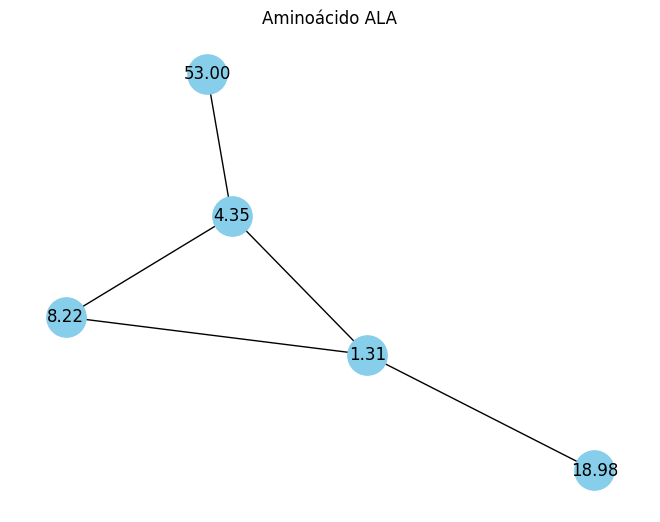

('GLY', {'CA': 45.0, 'HA2': 3.92, 'HA3': 3.91, 'HN': 8.0}, 1.0, <networkx.classes.graph.Graph object at 0x785cb9f0b450>)


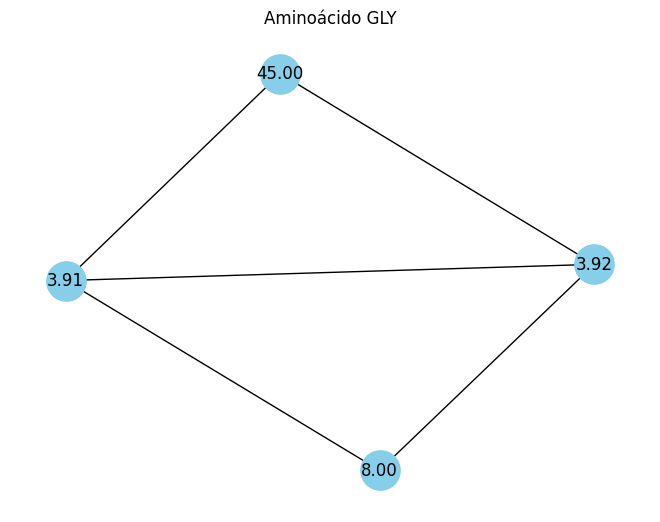

('PRO', {'CA': 63.326, 'HA': 4.38, 'CB': 31.876, 'HB2': 2.069, 'HB3': 1.997, 'CD': 50.344, 'HD2': 3.637, 'HD3': 3.603, 'CG': 27.265, 'HG': 1.918}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7d47f10>)


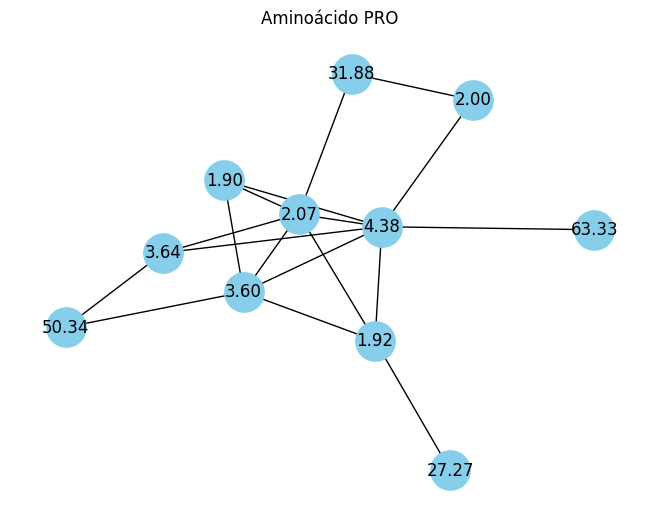

('ASN_OR_ASP', {'CA': 53.0, 'CB': 38.7, 'HB': 2.799, 'HA': 4.6, 'HN': 8.0}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7d76c10>)


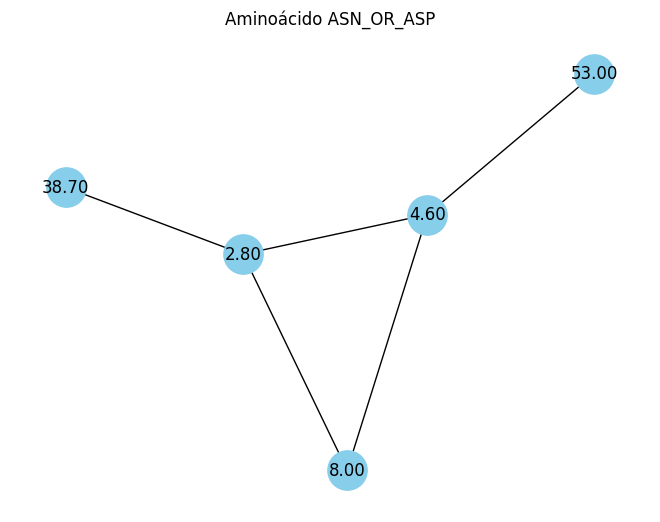

('PHE', {'CZ': 129.036, 'HZ': 6.99, 'CA': 58.0, 'CB': 40.0, 'HB2': 2.99, 'HB3': 2.93, 'HA': 4.6, 'HN': 8.0}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7dd7910>)


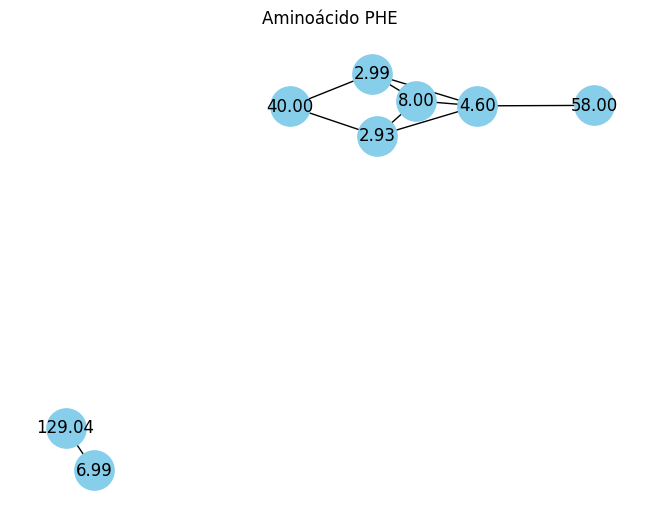

('TYR', {'CE': 117.0, 'CD': 132.0, 'CA': 58.0, 'CB': 39.0, 'HB2': 2.89, 'HB3': 2.83, 'HA': 4.6, 'HN': 8.0, 'HD': 6.91}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7da3d90>)


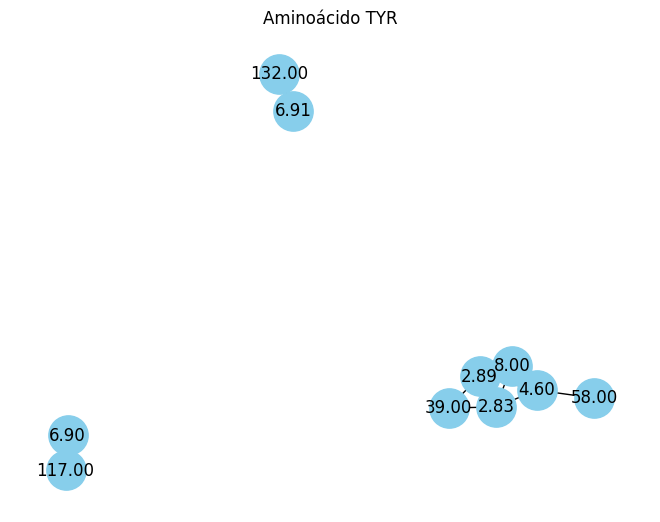

('HIS', {'CD2': 119.0, 'HD': 7.13, 'CA': 56.4, 'HA': 4.6, 'CB': 30.0, 'HB2': 3.1, 'HB3': 3.0, 'HN': 8.2}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7d979d0>)


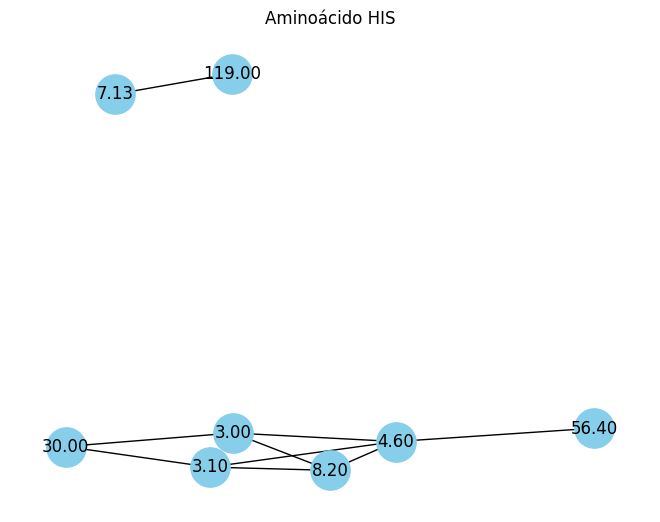

('TRP', {'CD': 126.3, 'HD1': 7.1, 'CA': 57.7, 'CB': 30.0, 'HB2': 3.17, 'HB3': 3.11, 'HA': 4.7, 'HN': 8.2}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7c11710>)


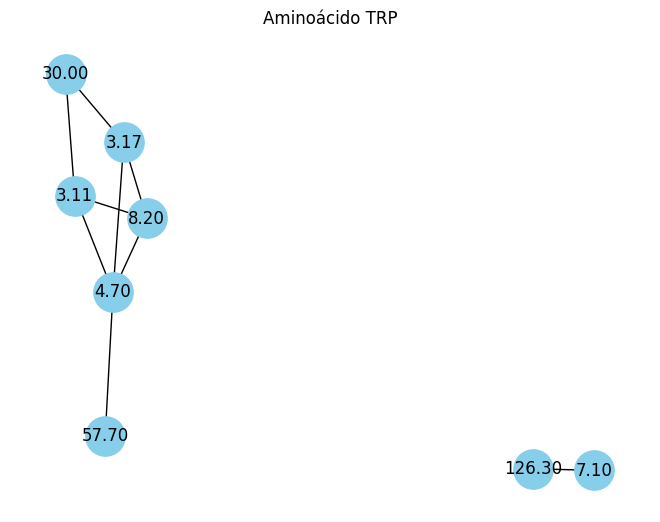

('CYS', {'CB': 33.5, 'HB2': 3.1, 'HB3': 3.04, 'CA': 57.9, 'HA': 4.6, 'HN': 8.4}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7c5ff10>)


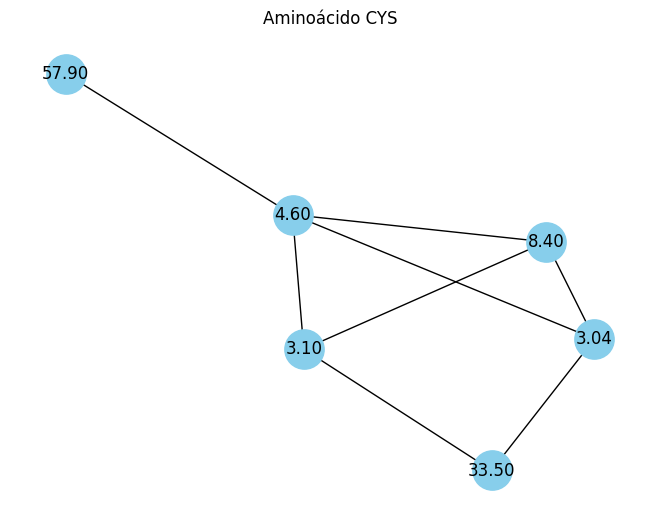

('MET', {'CB': 32.9, 'CG': 32.0, 'CE': 17.0, 'ME': 1.78, 'HG': 2.38, 'HB2': 2.1, 'HB3': 1.99, 'CA': 56.1, 'HA': 4.4, 'HN': 8.0}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7c5e310>)


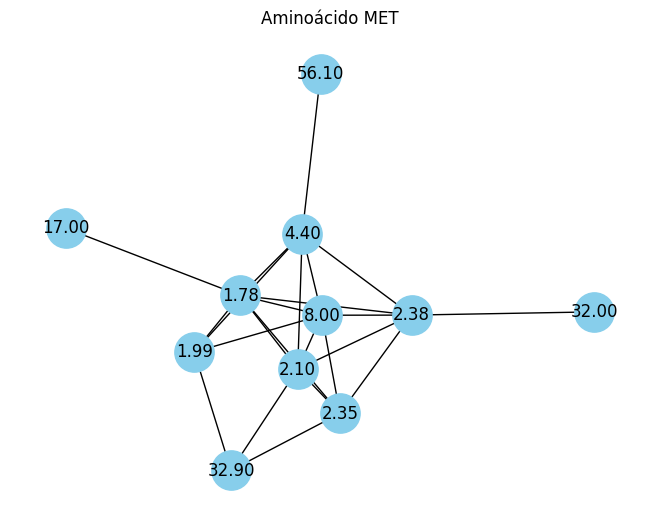

('LYS', {'CB': 33.0, 'HB2': 1.77, 'HB3': 1.74, 'CE': 42.0, 'HE2': 2.91, 'HE3': 2.9, 'CA': 57.0, 'HA': 4.2, 'CD': 29.0, 'HD2': 1.6, 'HD3': 1.55, 'CG': 24.0, 'HG2': 1.36, 'HG3': 1.34, 'HN': 8.1}, 1.0, <networkx.classes.graph.Graph object at 0x785cb9e2f910>)


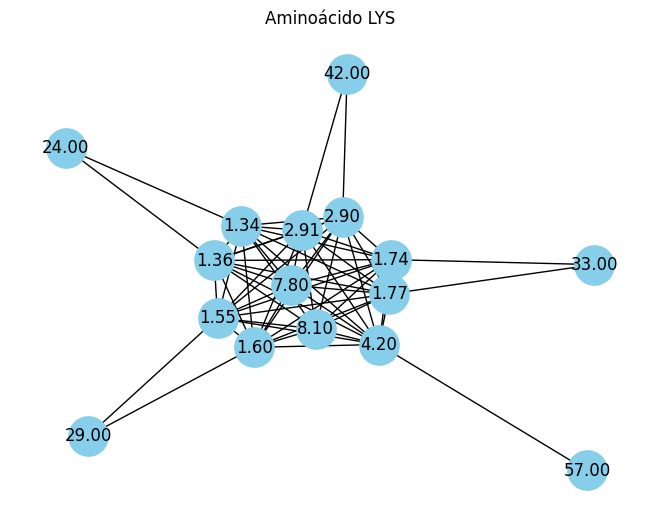

('LEU', {'HN': 8.172, 'CB': 41.044, 'HB': 1.575, 'CA': 58.167, 'HA': 3.977, 'CD1': 24.791, 'CD2': 24.565, 'MD1': 0.824, 'MD2': 0.822}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7ae7f10>)


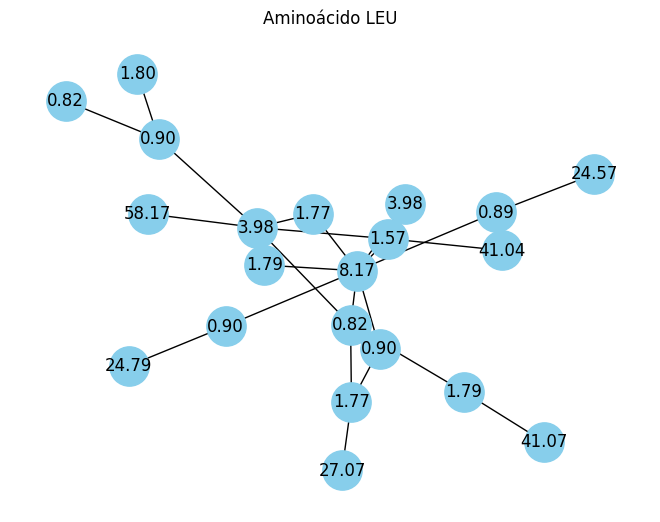

('GLN_OR_GLU', {'CA': 56.0, 'CB': 30.0, 'HA': 4.2, 'HB': 2.0, 'CG': 34.0, 'HG': 2.3, 'HN': 8.4}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7ae42d0>)


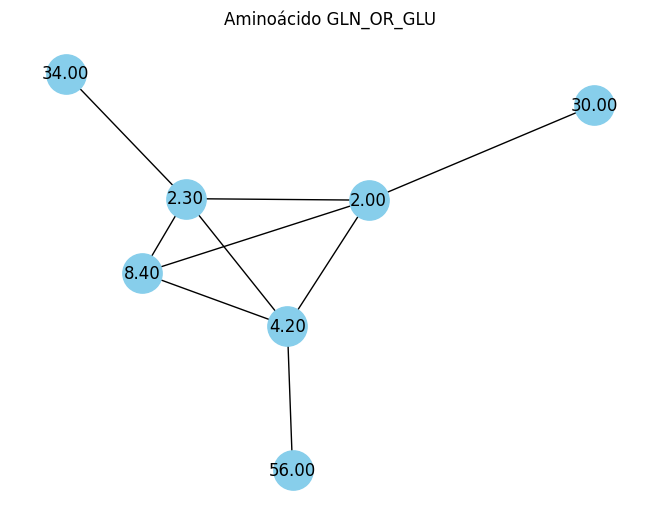

('SER', {'CB': 63.7, 'HB': 3.8, 'CA': 59.0, 'HA': 4.4, 'HN': 8.0}, 0.9999999999999999, <networkx.classes.graph.Graph object at 0x785cb7b50ed0>)


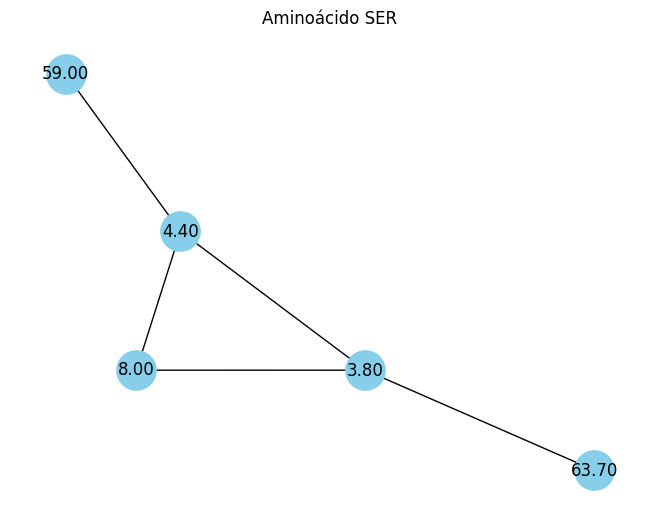

('THR', {'CB': 69.0, 'HB': 4.1, 'HN': 8.0, 'CG2': 21.0, 'MG': 1.13, 'CA': 62.0, 'HA': 4.4}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7dbe290>)


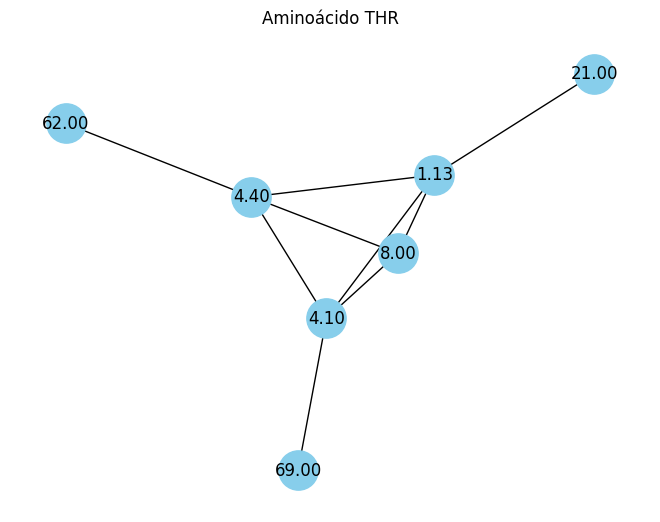

('VAL', {'MG1': 0.85, 'MG2': 0.8, 'CG1': 21.3, 'CG2': 21.0, 'CB': 32.0, 'HB': 2.0, 'CA': 62.2, 'HA': 4.2, 'HN': 8.0}, 1, <networkx.classes.graph.Graph object at 0x785cb7ce4c90>)


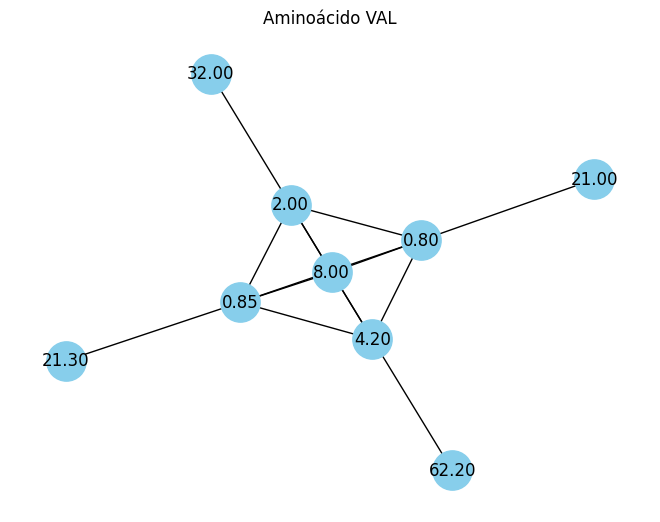

('ILE', {'CA': 62.0, 'CB': 39.0, 'HB': 1.8, 'HA': 4.1, 'CG1': 28.0, 'HG11': 1.2, 'HG12': 1.26, 'CG2': 17.5, 'MG': 0.7, 'CD1': 13.5, 'MD': 0.6, 'HN': 8.0}, 0.9, <networkx.classes.graph.Graph object at 0x785cb7b34050>)


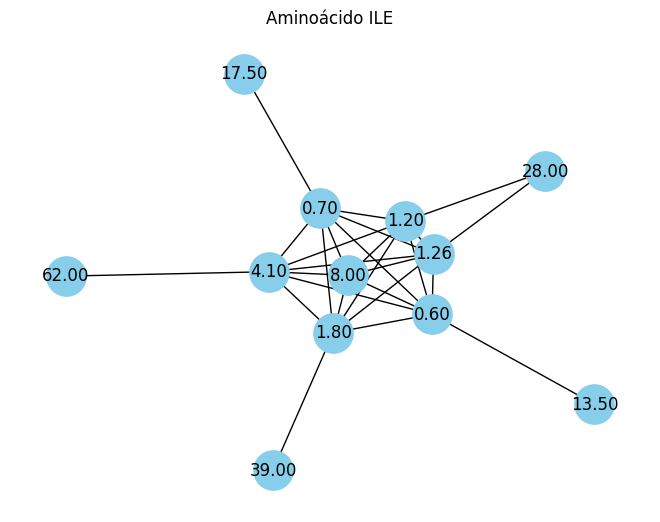

In [71]:
for i in residue_connections:
    a, b, c, G = identify_aa_v2(residue_connections[i])
    print(identify_aa_v2(residue_connections[i]))
    plot_graph(G, title=f"Aminoácido {a}")

### Tests

#### Test 1

9 - 12Phe
10 - Repetição de glicina (mal ajuste do código)


In [72]:
pk_2 = {0: ['4.136-8.218', '1.873-8.218','1.842-8.218','1.62-8.218', '0.862-8.218', '0.835-8.218', '41.97-1.842', '57.998-4.135', '41.97-1.873', '25.423-0.863', '23.349-0.835'],
        1: ['1.768-8.172', '1.575-8.172', '3.975-8.172', '1.794-8.172', '0.898-8.172', '0.824-8.172', '0.898-1.767', '0.824-1.767', '1.794-3.977', '1.768-3.977', '0.895-3.977', '1.575-3.977', '0.824-3.977', '0.895-1.796', '0.824-1.792', '0.895-0.822', '27.07-1.767', '41.044-1.575', '58.167-3.977', '41.067-1.792', '24.791-0.899', '24.565-0.899'],
        2: ['3.96-8.106', '3.895-8.106', '46.439-3.96','46.439-3.895'],
        3: ['3.788-8.076', '3.944-8.076', '7.897-3.943', '4.309-3.943', '46.338-3.789', '46.338-3.946'],
        4: ['4.08-8.052', '1.268-8.052', '4.296-8.052', '1.268-4.08', '8.052-4.08', '4.296-4.08', '4.08-1.268', '4.296-1.268', '1.268-4.296', '21.888-1.268', '69.096-4.296'],
        5: ['0.852-7.985', '0.898-7.985', '1.691-7.985', '1.643-7.985', '4.066-7.985','0.852-1.604', '0.898-1.604','0.852-1.643', '0.898-1.643','0.852-4.068', '0.852-1.691', '0.898-1.691','58.047-4.068', '42.043-1.691','42.043-1.643'],
        7: ['4.126-7.83', '1.354-7.83', '1.347-4.126', '4.126-1.347', '7.828-1.347', '52.58-4.126','19.6-1.347'],
        8: ['4.294-7.767', '3.89-7.767', '1.267-4.296', '4.29-3.889', '69.096-4.296', '63.242-3.889']}

In [73]:
import matplotlib.pyplot as plt

def visualize_graph(G, title="Graph"):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10)
    plt.title(title)
    plt.show()

In [74]:
identify_aa_v2([['4.136-8.218',
                 '1.873-8.218',
                 '1.842-8.218',
                 '1.62-8.218',
                 '0.862-8.218',
                 '0.835-8.218',
                 '41.97-1.842',
                 '57.998-4.135',
                 '41.97-1.873',
                 '25.423-0.863',
                 '23.349-0.835']], show_graph=True)

('UNKNOWN', {})

In [75]:
for i in pk_2:
    print(identify_aa_v2(pk_2[i], show_graph=True))

('LEU', {'HN': 8.218, 'CB': 41.97, 'HB2': 1.842, 'HB3': 1.873, 'CA': 57.998, 'HA': 4.135, 'CD': 23.349, 'MD1': 0.862, 'MD2': 0.835}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7dd4d10>)
('LEU', {'HN': 8.172, 'CB': 41.044, 'HB': 1.575, 'CA': 58.167, 'HA': 3.977, 'CD1': 24.791, 'CD2': 24.565, 'MD1': 0.824, 'MD2': 0.822}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7ced190>)
('GLY', {'CA': 46.439, 'HA2': 3.96, 'HA3': 3.895, 'HN': 8.106}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7ced190>)
('GLY', {'CA': 46.338, 'HA2': 3.946, 'HA3': 3.789, 'HN': 8.076}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7ced190>)
('THR', {'CB': 69.096, 'HB': 4.296, 'HN': 8.052, 'CG2': 21.888, 'MG': 1.268, 'HA': 4.08}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7ced190>)
('LEU', {'HN': 7.985, 'CB': 42.043, 'HB2': 1.643, 'HB3': 1.691, 'CA': 58.047, 'HA': 4.068, 'MD1': 0.898, 'MD2': 0.852}, 0.8, <networkx.classes.graph.Graph object at 0x785cb7ced190>)
('ALA', {'CB': 19.6, 

In [76]:
for cluster, pairs in pk_2.items():
    resultado = identify_aa_v2(pairs, show_graph=False)
    print(f"Cluster {cluster}: {resultado}")

Cluster 0: ('LEU', {'HN': 8.218, 'CB': 41.97, 'HB2': 1.842, 'HB3': 1.873, 'CA': 57.998, 'HA': 4.135, 'CD': 23.349, 'MD1': 0.862, 'MD2': 0.835}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7db1f90>)
Cluster 1: ('LEU', {'HN': 8.172, 'CB': 41.044, 'HB': 1.575, 'CA': 58.167, 'HA': 3.977, 'CD1': 24.791, 'CD2': 24.565, 'MD1': 0.824, 'MD2': 0.822}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7d46e10>)
Cluster 2: ('GLY', {'CA': 46.439, 'HA2': 3.96, 'HA3': 3.895, 'HN': 8.106}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7db1f90>)
Cluster 3: ('GLY', {'CA': 46.338, 'HA2': 3.946, 'HA3': 3.789, 'HN': 8.076}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7c05a50>)
Cluster 4: ('THR', {'CB': 69.096, 'HB': 4.296, 'HN': 8.052, 'CG2': 21.888, 'MG': 1.268, 'HA': 4.08}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7db1f90>)
Cluster 5: ('LEU', {'HN': 7.985, 'CB': 42.043, 'HB2': 1.643, 'HB3': 1.691, 'CA': 58.047, 'HA': 4.068, 'MD1': 0.898, 'MD2': 0.852}, 0.8, <networkx.cl

#### Test 2

In [77]:
test_2 = {0: ['1.62-8.218', '4.136-8.218', '1.873-8.218', '1.842-8.218', '0.862-8.218', '0.835-8.218', '41.884-1.62', '57.998-4.135', '41.97-1.873', '25.423-0.863', '23.349-0.835'], 1: ['1.768-8.172', '1.575-8.172', '3.975-8.172', '1.794-8.172', '0.898-8.172', '0.824-8.172', '0.898-1.767', '0.824-1.767', '1.794-3.977', '1.768-3.977', '0.898-3.977', '1.575-3.977', '0.824-3.977', '0.898-1.796', '0.824-1.796', '0.898-0.822', '27.07-1.767', '41.044-1.575', '58.167-3.977', '41.067-1.796', '24.791-0.899', '24.565-0.899'], 2: ['3.96-8.106', '3.895-8.106', '46.439-3.96'], 3: ['3.788-8.076', '3.944-8.076', '7.897-3.943', '4.309-3.943', '46.338-3.789', '46.587-3.943'], 4: ['4.08-8.052', '1.268-8.052', '4.296-8.052', '1.268-4.08', '8.052-4.08', '4.296-4.08', '4.08-1.268', '4.296-1.268', '1.268-4.296', '21.888-1.268', '69.096-4.296'], 5: ['1.603-7.985', '1.643-7.985', '0.848-7.985', '0.918-7.985', '4.066-7.985', '1.691-7.985', '0.848-1.604', '0.898-1.604', '0.848-1.643', '0.898-1.643', '0.848-4.068', '0.848-1.691', '0.898-1.691', '41.989-1.643', '58.047-4.068', '42.043-1.691'], 6: ['1.853-7.906', '1.411-7.906', '4.009-7.906', '1.627-7.906', '1.5-7.906', '1.5-1.853', '1.637-1.853', '4.009-1.853', '2.928-1.853', '1.411-1.853', '7.906-1.853', '2.928-1.41', '1.637-1.41', '4.009-1.41', '1.853-1.41', '1.5-1.41', '2.928-4.009', '25.105-1.41', '58.971-4.009'], 7: ['3.948-7.897', '4.31-7.897', '1.194-7.897', '1.194-3.948', '7.895-4.31', '3.948-4.31', '4.31-1.194', '3.948-1.194', '46.587-3.948', '21.76-1.194'], 8: ['4.126-7.83', '1.354-7.83', '1.354-4.126', '4.126-1.354', '7.828-1.354', '52.58-4.126'], 9: ['4.294-7.767', '3.89-7.767', '1.267-4.296', '4.294-3.889', '69.096-4.296', '63.242-3.889'], 10: ['3.126-7.712', '4.426-7.712', '39.593-3.126']}

In [78]:
for n,i in enumerate(test_2):
  print(f"{n}: {test_2[i]}")

0: ['1.62-8.218', '4.136-8.218', '1.873-8.218', '1.842-8.218', '0.862-8.218', '0.835-8.218', '41.884-1.62', '57.998-4.135', '41.97-1.873', '25.423-0.863', '23.349-0.835']
1: ['1.768-8.172', '1.575-8.172', '3.975-8.172', '1.794-8.172', '0.898-8.172', '0.824-8.172', '0.898-1.767', '0.824-1.767', '1.794-3.977', '1.768-3.977', '0.898-3.977', '1.575-3.977', '0.824-3.977', '0.898-1.796', '0.824-1.796', '0.898-0.822', '27.07-1.767', '41.044-1.575', '58.167-3.977', '41.067-1.796', '24.791-0.899', '24.565-0.899']
2: ['3.96-8.106', '3.895-8.106', '46.439-3.96']
3: ['3.788-8.076', '3.944-8.076', '7.897-3.943', '4.309-3.943', '46.338-3.789', '46.587-3.943']
4: ['4.08-8.052', '1.268-8.052', '4.296-8.052', '1.268-4.08', '8.052-4.08', '4.296-4.08', '4.08-1.268', '4.296-1.268', '1.268-4.296', '21.888-1.268', '69.096-4.296']
5: ['1.603-7.985', '1.643-7.985', '0.848-7.985', '0.918-7.985', '4.066-7.985', '1.691-7.985', '0.848-1.604', '0.898-1.604', '0.848-1.643', '0.898-1.643', '0.848-4.068', '0.848-1.69

In [79]:
for i in test_2:
    a, b, c, G = identify_aa_v2(test_2[i])
    print(f"{i},{identify_aa_v2(test_2[i])}")

0,('LEU', {'HN': 8.218, 'CB': 41.884, 'HB': 1.62, 'CA': 57.998, 'HA': 4.135, 'CD': 23.349, 'MD1': 0.862, 'MD2': 0.835}, 1.0, <networkx.classes.graph.Graph object at 0x785cb9f37510>)
1,('LEU', {'HN': 8.172, 'CB': 41.044, 'HB': 1.575, 'CA': 58.167, 'HA': 3.977, 'CD1': 24.791, 'CD2': 24.565, 'MD1': 0.824, 'MD2': 0.822}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7dd53d0>)
2,('GLY', {'CA': 46.439, 'HA': 3.96, 'HN': 8.106}, 1.0, <networkx.classes.graph.Graph object at 0x785cb9f36810>)
3,('GLY', {'CA': 46.587, 'HA': 3.943, 'HN': 8.076}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7dd53d0>)
4,('THR', {'CB': 69.096, 'HB': 4.296, 'HN': 8.052, 'CG2': 21.888, 'MG': 1.268, 'HA': 4.08}, 1.0, <networkx.classes.graph.Graph object at 0x785cb7ced310>)
5,('LEU', {'HN': 7.985, 'CB': 41.989, 'HB': 1.643, 'CA': 58.047, 'HA': 4.068, 'MD1': 0.898, 'MD2': 0.848}, 0.8, <networkx.classes.graph.Graph object at 0x785cb7c05e50>)
6,('UNKNOWN', {}, 0.0, <networkx.classes.graph.Graph object at 0x785c

In [81]:
result_dict = {}

for key in test_2:
    aa_name, atoms_dict, confidence, G = identify_aa_v2(test_2[key])
    result_dict[key] = {
        'amino_acid': aa_name,
        'atoms': atoms_dict,
        'confidence': confidence
    }

# To access the results:
print(result_dict)

{0: {'amino_acid': 'LEU', 'atoms': {'HN': 8.218, 'CB': 41.884, 'HB': 1.62, 'CA': 57.998, 'HA': 4.135, 'CD': 23.349, 'MD1': 0.862, 'MD2': 0.835}, 'confidence': 1.0}, 1: {'amino_acid': 'LEU', 'atoms': {'HN': 8.172, 'CB': 41.044, 'HB': 1.575, 'CA': 58.167, 'HA': 3.977, 'CD1': 24.791, 'CD2': 24.565, 'MD1': 0.824, 'MD2': 0.822}, 'confidence': 1.0}, 2: {'amino_acid': 'GLY', 'atoms': {'CA': 46.439, 'HA': 3.96, 'HN': 8.106}, 'confidence': 1.0}, 3: {'amino_acid': 'GLY', 'atoms': {'CA': 46.587, 'HA': 3.943, 'HN': 8.076}, 'confidence': 1.0}, 4: {'amino_acid': 'THR', 'atoms': {'CB': 69.096, 'HB': 4.296, 'HN': 8.052, 'CG2': 21.888, 'MG': 1.268, 'HA': 4.08}, 'confidence': 1.0}, 5: {'amino_acid': 'LEU', 'atoms': {'HN': 7.985, 'CB': 41.989, 'HB': 1.643, 'CA': 58.047, 'HA': 4.068, 'MD1': 0.898, 'MD2': 0.848}, 'confidence': 0.8}, 6: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}, 7: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}, 8: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidenc

In [83]:
for i in result_dict:
  print(f"{i} - {result_dict[i]}")

0 - {'amino_acid': 'LEU', 'atoms': {'HN': 8.218, 'CB': 41.884, 'HB': 1.62, 'CA': 57.998, 'HA': 4.135, 'CD': 23.349, 'MD1': 0.862, 'MD2': 0.835}, 'confidence': 1.0}
1 - {'amino_acid': 'LEU', 'atoms': {'HN': 8.172, 'CB': 41.044, 'HB': 1.575, 'CA': 58.167, 'HA': 3.977, 'CD1': 24.791, 'CD2': 24.565, 'MD1': 0.824, 'MD2': 0.822}, 'confidence': 1.0}
2 - {'amino_acid': 'GLY', 'atoms': {'CA': 46.439, 'HA': 3.96, 'HN': 8.106}, 'confidence': 1.0}
3 - {'amino_acid': 'GLY', 'atoms': {'CA': 46.587, 'HA': 3.943, 'HN': 8.076}, 'confidence': 1.0}
4 - {'amino_acid': 'THR', 'atoms': {'CB': 69.096, 'HB': 4.296, 'HN': 8.052, 'CG2': 21.888, 'MG': 1.268, 'HA': 4.08}, 'confidence': 1.0}
5 - {'amino_acid': 'LEU', 'atoms': {'HN': 7.985, 'CB': 41.989, 'HB': 1.643, 'CA': 58.047, 'HA': 4.068, 'MD1': 0.898, 'MD2': 0.848}, 'confidence': 0.8}
6 - {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}
7 - {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}
8 - {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidenc

#### Test 3

In [123]:
test_3 = {0: ['1.62-8.218', '4.136-8.218', '1.873-8.218', '1.842-8.218', '0.862-8.218', '0.835-8.213', '41.884-1.62', '57.998-4.136', '41.97-1.873', '25.122-0.862', '25.423-0.862', '23.349-0.835'], 1: ['1.768-8.172', '1.575-8.172', '3.975-8.172', '1.794-8.172', '0.898-8.172', '0.824-8.172', '0.898-1.768', '0.824-1.768', '1.794-3.975', '1.768-3.975', '0.898-3.975', '1.575-3.975', '0.824-3.975', '0.898-1.794', '0.824-1.794', '0.898-0.824', '27.07-1.768', '41.044-1.575', '58.167-3.975', '41.067-1.794', '24.791-0.898', '24.565-0.898', '23.68-0.824'], 2: ['3.96-8.106', '3.895-8.106', '46.439-3.96'], 3: ['3.788-8.076', '3.944-8.076', '7.897-3.944', '46.338-3.788', '46.587-3.944'], 4: ['4.08-8.052', '1.268-8.052', '4.296-8.052', '1.268-4.08', '8.052-4.08', '4.08-1.268', '4.296-1.268', '1.268-4.296', '64.616-4.08', '21.888-1.268', '69.096-4.296', '60.408-4.291'], 5: ['1.603-7.985', '1.643-7.985', '0.848-7.985', '0.918-7.985', '4.066-7.985', '1.691-7.985', '0.848-1.603', '0.898-1.603', '0.848-1.643', '0.898-1.643', '0.848-4.066', '0.853-1.691', '0.898-1.691', '41.989-1.643', '58.047-4.066', '42.043-1.691'], 6: ['1.853-7.906', '1.411-7.906', '4.009-7.906', '1.627-7.906', '1.5-7.906', '1.5-1.853', '1.637-1.853', '4.009-1.853', '1.411-1.853', '7.906-1.853', '1.637-1.411', '4.009-1.411', '1.853-1.411', '1.5-1.411', '31.923-1.848', '25.105-1.411', '58.971-4.009', '25.112-1.495'], 7: ['3.948-7.897', '4.31-7.897', '1.194-7.897', '1.194-3.948', '7.897-4.31', '4.31-1.194', '3.948-1.194', '46.587-3.948', '21.76-1.194'], 8: ['4.126-7.83', '1.354-7.83', '1.354-4.126', '4.126-1.354', '7.83-1.354', '52.58-4.126', '27.729-1.354'], 9: ['4.294-7.767', '3.89-7.767', '1.267-4.294', '69.096-4.294', '60.408-4.294', '63.242-3.89'], 10: ['3.126-7.712', '4.426-7.712', '39.593-3.126','7.712-7.252','131.375-7.214']}

In [42]:
test_3 = {0: ['3.123-4.419', '4.419-7.252', '39.593-3.123'], 1: ['3.27-4.35', '4.35-7.348', '39.373-3.27'], 2: ['1.195-4.313', '3.946-4.313', '3.946-1.195', '21.76-1.195', '46.587-3.946'], 3: ['1.267-4.296', '4.08-1.267', '21.888-1.267'], 4: ['4.078-4.291', '3.891-4.291', '8.052-4.078', '64.616-4.078', '63.242-3.891'], 5: ['1.623-4.133', '1.842-4.133', '1.873-4.133', '0.865-4.133', '0.834-4.133', '1.354-4.126', '7.828-1.354', '41.884-1.623', '31.923-1.848', '41.97-1.873', '25.122-0.858', '25.423-0.858', '23.68-0.827', '23.349-0.834', '19.601-1.347', '27.729-1.347'], 6: ['1.269-4.08', '4.294-4.08', '4.294-1.269', '21.888-1.269', '69.096-4.294', '60.408-4.294'], 7: ['1.642-4.07', '1.692-4.07', '0.899-4.07', '1.597-4.07', '0.852-4.07', '0.852-1.642', '0.899-1.642', '0.852-1.692', '0.899-1.692', '41.989-1.642', '42.043-1.692', '24.791-0.899', '24.565-0.899', '27.239-1.59', '25.122-0.858'], 8: ['1.409-4.017', '1.635-4.017', '1.496-4.017', '1.853-4.017', '2.929-1.409', '1.635-1.409', '4.008-1.409', '1.853-1.409', '1.496-1.409', '4.008-1.635', '2.929-1.635', '1.853-1.635', '1.496-1.635', '2.929-1.496', '1.853-1.496', '4.008-1.496', '4.008-1.853', '2.929-1.853', '7.906-1.853', '25.105-1.409', '29.034-1.635', '25.112-1.496', '31.923-1.853'], 9: ['2.93-4.009', '1.853-2.93', '42.159-2.93'], 10: ['1.796-3.977', '1.768-3.977', '0.895-3.977', '1.574-3.977', '0.823-3.977', '0.895-1.796', '0.895-1.768', '0.823-1.768', '0.823-0.895', '41.067-1.796', '27.07-1.768', '24.791-0.895', '24.565-0.895', '41.044-1.574', '23.68-0.823'], 11: ['1.193-3.948', '4.312-1.193', '21.76-1.193'], 12: ['4.309-3.942', '7.895-4.309'], 13: ['0.993-3.937', '1.867-3.937', '1.349-3.937', '0.81-3.937', '0.797-3.937', '0.81-1.867', '1.349-1.867', '0.797-1.349', '0.81-1.349', '41.97-1.873', '38.27-1.867', '19.601-1.349', '27.729-1.349', '17.767-0.81', '13.578-0.797'], 14: ['4.29-3.889', '69.096-4.29', '60.408-4.29']}

In [37]:
test_3 = {0: ['3.123-4.419', '4.419-7.252', '39.593-3.123'], 1: ['3.27-4.35', '4.35-7.348', '39.373-3.27'], 2: ['1.195-4.313', '3.946-4.313', '3.946-1.195', '21.76-1.195', '46.587-3.946', '46.439-3.96', '46.345-3.904', '58.167-3.975', '62.539-3.935', '66.151-3.935'], 3: ['1.267-4.296', '4.078-4.296', '3.891-4.29', '4.078-1.267', '8.052-4.078', '21.888-1.267', '58.047-4.066', '64.616-4.078', '52.58-4.127', '46.345-3.904', '62.539-3.935', '63.242-3.891', '66.151-3.935'], 4: ['1.623-4.133', '1.842-4.133', '1.873-4.133', '0.865-4.133', '0.834-4.133', '1.354-4.126', '7.828-1.354', '41.989-1.643', '27.239-1.59', '41.044-1.575', '29.034-1.633', '41.884-1.623', '41.067-1.794', '31.923-1.848', '41.97-1.873', '26.805-1.833', '38.27-1.862', '24.791-0.899', '25.122-0.858', '23.68-0.827', '24.565-0.899', '25.423-0.858', '23.349-0.834', '13.578-0.795', '17.767-0.808', '19.601-1.347', '27.729-1.347'], 5: ['1.269-4.08', '4.294-4.08', '4.294-1.269', '21.888-1.269', '69.096-4.294', '60.408-4.294'], 6: ['1.642-4.07', '1.692-4.07', '0.899-4.07', '1.597-4.07', '0.852-4.07', '0.852-1.642', '0.899-1.642', '0.852-1.692', '0.899-1.692', '41.989-1.642', '42.043-1.692', '29.034-1.633', '41.884-1.62', '24.791-0.899', '25.122-0.858', '24.565-0.899', '25.423-0.858', '27.239-1.59', '41.044-1.575', '23.68-0.827', '23.349-0.835', '17.767-0.808'], 7: ['1.409-4.017', '1.635-4.017', '1.496-4.017', '1.853-4.017', '2.929-1.409', '1.635-1.409', '4.008-1.409', '1.853-1.409', '1.496-1.409', '4.008-1.635', '2.929-1.635', '1.853-1.635', '1.496-1.635', '2.929-1.496', '1.853-1.496', '4.008-1.496', '4.008-1.853', '2.929-1.853', '7.906-1.853', '25.105-1.409', '41.989-1.643', '27.239-1.59', '29.034-1.635', '41.884-1.62', '25.112-1.496', '31.923-1.853', '41.97-1.873', '26.805-1.833', '38.27-1.862'], 8: ['2.93-4.009', '1.853-2.93', '42.159-2.93'], 9: ['1.796-3.977', '1.768-3.977', '0.895-3.977', '1.574-3.977', '0.823-3.977', '0.895-1.796', '0.895-1.768', '0.823-1.768', '0.823-0.895', '41.067-1.796', '27.07-1.768', '26.805-1.833', '24.791-0.895', '25.122-0.858', '24.565-0.895', '25.423-0.858', '27.239-1.59', '41.044-1.574', '41.884-1.62', '23.68-0.823', '23.349-0.835', '13.578-0.795', '17.767-0.808'], 10: ['1.193-3.948', '4.312-1.193', '21.76-1.193'], 11: ['4.309-3.942', '0.993-3.942', '1.867-3.936', '1.349-3.936', '0.81-3.936', '0.797-3.936', '7.895-4.309', '0.81-1.867', '1.349-1.867', '0.797-1.349', '0.81-1.349', '69.096-4.295', '60.408-4.295', '57.868-4.354', '27.696-0.981', '31.923-1.848', '41.97-1.873', '26.805-1.833', '38.27-1.867', '19.601-1.349', '27.729-1.349', '25.122-0.858', '23.68-0.827', '23.349-0.835', '13.578-0.797', '17.767-0.81'], 12: ['4.29-3.889', '69.096-4.29', '60.408-4.29']}

In [44]:
print("Keys in test_3:", test_3.keys())
print("Sample values:")
for i, key in enumerate(test_3):
  print(f"{key}: {test_3[key]}")

Keys in test_3: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
Sample values:
0: ['3.123-4.419', '4.419-7.252', '39.593-3.123']
1: ['3.27-4.35', '4.35-7.348', '39.373-3.27']
2: ['1.195-4.313', '3.946-4.313', '3.946-1.195', '21.76-1.195', '46.587-3.946']
3: ['1.267-4.296', '4.08-1.267', '21.888-1.267']
4: ['4.078-4.291', '3.891-4.291', '8.052-4.078', '64.616-4.078', '63.242-3.891']
5: ['1.623-4.133', '1.842-4.133', '1.873-4.133', '0.865-4.133', '0.834-4.133', '1.354-4.126', '7.828-1.354', '41.884-1.623', '31.923-1.848', '41.97-1.873', '25.122-0.858', '25.423-0.858', '23.68-0.827', '23.349-0.834', '19.601-1.347', '27.729-1.347']
6: ['1.269-4.08', '4.294-4.08', '4.294-1.269', '21.888-1.269', '69.096-4.294', '60.408-4.294']
7: ['1.642-4.07', '1.692-4.07', '0.899-4.07', '1.597-4.07', '0.852-4.07', '0.852-1.642', '0.899-1.642', '0.852-1.692', '0.899-1.692', '41.989-1.642', '42.043-1.692', '24.791-0.899', '24.565-0.899', '27.239-1.59', '25.122-0.858']
8: ['1.409-4.017', '1.635-

In [45]:
for i in test_3:
    try:
        a, b, c, G = identify_aa_v2(test_3[i])
        print(f"{i}, {a}, {b}, {c}, {G}")
    except Exception as e:
        print(f"Error at {i}: {str(e)}")
        print(f"Problematic value: {test_3[i]}")

0, UNKNOWN, {}, 0.0, Graph with 4 nodes and 3 edges
1, UNKNOWN, {}, 0.0, Graph with 4 nodes and 3 edges
2, UNKNOWN, {}, 0.0, Graph with 5 nodes and 5 edges
3, UNKNOWN, {}, 0.0, Graph with 4 nodes and 3 edges
4, UNKNOWN, {}, 0.0, Graph with 6 nodes and 5 edges
5, ALA, {'CB': 19.601, 'HB': 1.347}, 0.7, Graph with 22 nodes and 16 edges
6, THR, {'CB': 69.096, 'HB': 4.294, 'CG2': 21.888, 'MG': 1.269, 'CA': 60.408, 'HA': 4.294}, 1.0, Graph with 6 nodes and 6 edges
7, UNKNOWN, {}, 0.0, Graph with 14 nodes and 15 edges
8, UNKNOWN, {}, 0.0, Graph with 12 nodes and 23 edges
9, UNKNOWN, {}, 0.0, Graph with 4 nodes and 3 edges
10, UNKNOWN, {}, 0.0, Graph with 12 nodes and 15 edges
11, UNKNOWN, {}, 0.0, Graph with 4 nodes and 3 edges
12, UNKNOWN, {}, 0.0, Graph with 3 nodes and 2 edges
13, ALA, {'CB': 19.601, 'HB': 1.349}, 0.7, Graph with 13 nodes and 15 edges
14, THR, {'CB': 69.096, 'HB': 4.29, 'CA': 60.408, 'HA': 4.29}, 0.9000000000000001, Graph with 4 nodes and 3 edges


In [38]:
for i in test_3:
    a, b, c, G = identify_aa_v2(test_3[i])
    print(f"{i},{identify_aa_v2(test_3[i])}")

0,('UNKNOWN', {}, 0.0, <networkx.classes.graph.Graph object at 0x7c9b7ca57fd0>)
1,('UNKNOWN', {}, 0.0, <networkx.classes.graph.Graph object at 0x7c9b7ca55390>)
2,('SER', {'CB': 62.539, 'HB': 3.935, 'CA': 58.167}, 0.8999999999999999, <networkx.classes.graph.Graph object at 0x7c9b7ca554d0>)
3,('UNKNOWN', {}, 0.0, <networkx.classes.graph.Graph object at 0x7c9b7c9e0650>)
4,('ALA', {'CB': 19.601, 'HB': 1.347}, 0.7, <networkx.classes.graph.Graph object at 0x7c9bc45dcb50>)
5,('THR', {'CB': 69.096, 'HB': 4.294, 'CG2': 21.888, 'MG': 1.269, 'CA': 60.408, 'HA': 4.294}, 1.0, <networkx.classes.graph.Graph object at 0x7c9bc45d2450>)
6,('UNKNOWN', {}, 0.0, <networkx.classes.graph.Graph object at 0x7c9b7c9f6450>)
7,('UNKNOWN', {}, 0.0, <networkx.classes.graph.Graph object at 0x7c9b7ca56450>)
8,('UNKNOWN', {}, 0.0, <networkx.classes.graph.Graph object at 0x7c9bc45dcb50>)
9,('UNKNOWN', {}, 0.0, <networkx.classes.graph.Graph object at 0x7c9b7ca56450>)
10,('UNKNOWN', {}, 0.0, <networkx.classes.graph.Graph

In [134]:
result_dict = {}

for key in test_3:
    aa_name, atoms_dict, confidence, G = identify_aa_v2(test_3[key])
    result_dict[key] = {
        'amino_acid': aa_name,
        'atoms': atoms_dict,
        'confidence': confidence
    }

# To access the results:
print(result_dict)

{0: {'amino_acid': 'LEU', 'atoms': {'HN': 8.218, 'CB': 41.884, 'HB': 1.62, 'CA': 57.998, 'HA': 4.136, 'CD': 23.349, 'MD1': 0.862, 'MD2': 0.835}, 'confidence': 1.0}, 1: {'amino_acid': 'LEU', 'atoms': {'HN': 8.172, 'CB': 41.044, 'HB': 1.575, 'CA': 58.167, 'HA': 3.975, 'CD1': 24.565, 'CD2': 23.68, 'MD1': 0.898, 'MD2': 0.824}, 'confidence': 1.0}, 2: {'amino_acid': 'GLY', 'atoms': {'CA': 46.439, 'HA': 3.96, 'HN': 8.106}, 'confidence': 1.0}, 3: {'amino_acid': 'GLY', 'atoms': {'CA': 46.587, 'HA': 3.944, 'HN': 8.076}, 'confidence': 1.0}, 4: {'amino_acid': 'THR', 'atoms': {'CB': 69.096, 'HB': 4.296, 'HN': 8.052, 'CG2': 21.888, 'MG': 1.268, 'CA': 64.616, 'HA': 4.08}, 'confidence': 1.0}, 5: {'amino_acid': 'LEU', 'atoms': {'HN': 7.985, 'CB': 41.989, 'HB': 1.643, 'CA': 58.047, 'HA': 4.066, 'MD1': 0.853, 'MD2': 0.848}, 'confidence': 0.8}, 6: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}, 7: {'amino_acid': 'UNKNOWN', 'atoms': {}, 'confidence': 0.0}, 8: {'amino_acid': 'UNKNOWN', 'atoms': {